In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import numpy as np

import sklearn
import sklearn.metrics
import matplotlib
import scipy
import mplhep

import pandas
import boost_histogram as bh
import itertools
import mplhep
mplhep.set_style(mplhep.styles.CMS)

<ipython-input-2-6ac9f5b9cdbb>:17: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  mplhep.set_style(mplhep.styles.CMS)


In [3]:
def flatten(arr):
    #return arr.reshape((arr.shape[0]*arr.shape[1], arr.shape[2]))
    return arr.reshape(-1, arr.shape[-1])

In [4]:
def cms_label(ax, x0=0.01, x1=0.15, x2=0.98, y=0.94):
    plt.figtext(x0, y,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', transform=ax.transAxes)
    plt.figtext(x1, y,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', transform=ax.transAxes)
    plt.figtext(x2, y,'Run 3 (14 TeV)',  wrap=False, horizontalalignment='right', transform=ax.transAxes)

# def cms_label_sample_label(x0=0.12, x1=0.23, x2=0.67, y=0.90):
#     plt.figtext(x0, y,'CMS',fontweight='bold', wrap=True, horizontalalignment='left')
#     plt.figtext(x1, y,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left')
#     plt.figtext(x2, y,'Run 3 (14 TeV), $\mathrm{t}\overline{\mathrm{t}}$ events',  wrap=False, horizontalalignment='left')

    
def sample_label(ax, additional_text="", x=0.01, y=0.87):
    plt.text(x, y, "$\mathrm{t}\overline{\mathrm{t}}$ events"+additional_text, ha="left", transform=ax.transAxes)

In [5]:
def apply_thresholds_f(ypred_raw_f, thresholds):
    msk = np.ones_like(ypred_raw_f)
    for i in range(len(thresholds)):
        msk[:, i+1] = ypred_raw_f[:, i+1]>thresholds[i]
    ypred_id_f = np.argmax(ypred_raw_f*msk, axis=-1)
    
#     best_2 = np.partition(ypred_raw_f, -2, axis=-1)[..., -2:]
#     diff = np.abs(best_2[:, -1] - best_2[:, -2])
#     ypred_id_f[diff<0.05] = 0
    
    return ypred_id_f

def apply_thresholds(ypred_raw, thresholds):
    msk = np.ones_like(ypred_raw)
    for i in range(len(thresholds)):
        msk[:, :, i+1] = ypred_raw[:, :, i+1]>thresholds[i]
    ypred_id = np.argmax(ypred_raw*msk, axis=-1)
    
#     best_2 = np.partition(ypred_raw, -2, axis=-1)[..., -2:]
#     diff = np.abs(best_2[:, :, -1] - best_2[:, :, -2])
#     ypred_id[diff<0.05] = 0
    
    return ypred_id

In [6]:
CMS_PF_CLASS_NAMES = ["none" "charged hadron", "neutral hadron", "hfem", "hfhad", "photon", "electron", "muon"]

ELEM_LABELS_CMS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ELEM_NAMES_CMS = ["NONE", "TRACK", "PS1", "PS2", "ECAL", "HCAL", "GSF", "BREM", "HFEM", "HFHAD", "SC", "HO"]

CLASS_LABELS_CMS = [0, 211, 130, 1, 2, 22, 11, 13, 15]
CLASS_NAMES_CMS = ["none", "ch.had", "n.had", "HFEM", "HFHAD", "$\gamma$", "$e^\pm$", "$\mu^\pm$", r"$\tau$"]

class_names = {k: v for k, v in zip(CLASS_LABELS_CMS, CLASS_NAMES_CMS)}

In [7]:
path = "../experiments/MLPF_final/testing_epoch_-1/predictions/"
path = "./pred/"

In [8]:
Xs = []
yvals = {}
for fi in list(glob.glob(path + "/pred_batch*.npz")):
    dd = np.load(fi)
    Xs.append(dd["X"])
    
    keys_in_file = list(dd.keys())
    for k in keys_in_file:
        if k=="X":
            continue
        if not (k in yvals):
            yvals[k] = []
        yvals[k].append(dd[k])

X = np.concatenate(Xs)
X_f = flatten(X)

msk_X_f = X_f[:, 0] != 0

yvals = {k: np.concatenate(v) for k, v in yvals.items()}

for val in ["gen", "cand", "pred"]:
    yvals["{}_phi".format(val)] = np.arctan2(yvals["{}_sin_phi".format(val)], yvals["{}_cos_phi".format(val)])
    yvals["{}_cls_id".format(val)] = np.expand_dims(np.argmax(yvals["{}_cls".format(val)], axis=-1), axis=-1)

    yvals["{}_px".format(val)] = np.sin(yvals["{}_phi".format(val)])*yvals["{}_pt".format(val)]
    yvals["{}_py".format(val)] = np.cos(yvals["{}_phi".format(val)])*yvals["{}_pt".format(val)]
    
yvals_f = {k: flatten(v) for k, v in yvals.items()}

#remove the last dim
for k in yvals_f.keys():
    if yvals_f[k].shape[-1] == 1:
        yvals_f[k] = yvals_f[k][..., -1]

In [9]:
len(Xs)

3

In [10]:
def get_distribution(prefix, bins, var):

    hists = []
    for pid in [13,11,22,1,2,130,211]:
        icls = CLASS_LABELS_CMS.index(pid)
        msk_pid = (yvals_f[prefix+"_cls_id"]==icls)
        h = bh.Histogram(bh.axis.Variable(bins))
        d = yvals_f[prefix + "_" + var][msk_pid]
        h.fill(d.flatten())
        hists.append(h)
    return hists

#     plt.figure(figsize=(5,5))
#     ax = plt.axes()
    
#     mplhep.histplot(
#         [h[0] for h in hists], bins=hists[0][1], ax=ax, stack=True, histtype="fill",
#         label=labels
#     )
#     plt.legend(ncol=2, frameon=False)
#     plt.xlabel(var)
#     cms_label(x1=0.22, x2=0.55)
#     plt.ylabel("Number of particles / bin")
#     plt.text(0.02, 0.95, particle_label, transform=ax.transAxes)
#     return ax

In [11]:
CLASS_LABELS_CMS.index(13)

7

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


Text(1, 0, 'PFCandidate $p_T$ [GeV]')

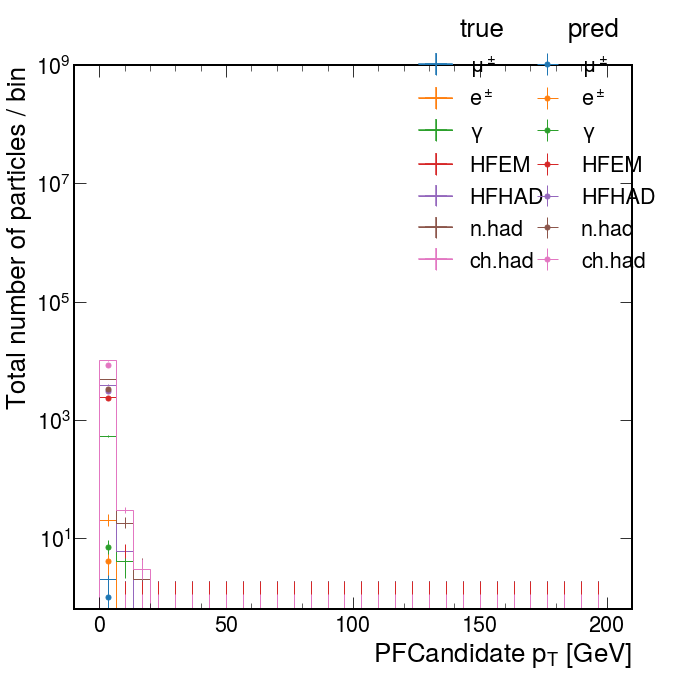

In [14]:
hists_gen = get_distribution("gen", np.linspace(0,200,61), "pt")
hists_cand = get_distribution("cand", np.linspace(0,200,61), "pt")
hists_pred = get_distribution("pred", np.linspace(0,200,61), "pt")

ax = plt.axes()
v1 = mplhep.histplot([h[bh.rebin(2)] for h in hists_gen], stack=True, label=[class_names[k] for k in [13,11,22,1,2,130,211]], lw=1)
v2 = mplhep.histplot([h[bh.rebin(2)] for h in hists_pred], stack=True, color=[x.stairs.get_edgecolor() for x in v1], lw=2, histtype="errorbar")

legend1 = plt.legend(v1, [x.legend_artist.get_label() for x in v1], loc=(0.60, 0.6), title="true")
legend2 = plt.legend(v2, [x.legend_artist.get_label() for x in v1], loc=(0.8, 0.6), title="pred")
plt.gca().add_artist(legend1)
plt.ylabel("Total number of particles / bin")
# cms_label(ax)
# sample_label(ax)

plt.yscale("log")
plt.ylim(top=1e9)
plt.xlabel("PFCandidate $p_T$ [GeV]")

# plt.savefig("pt_true_vs_pred.pdf", bbox_inches="tight")

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale
/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale
/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


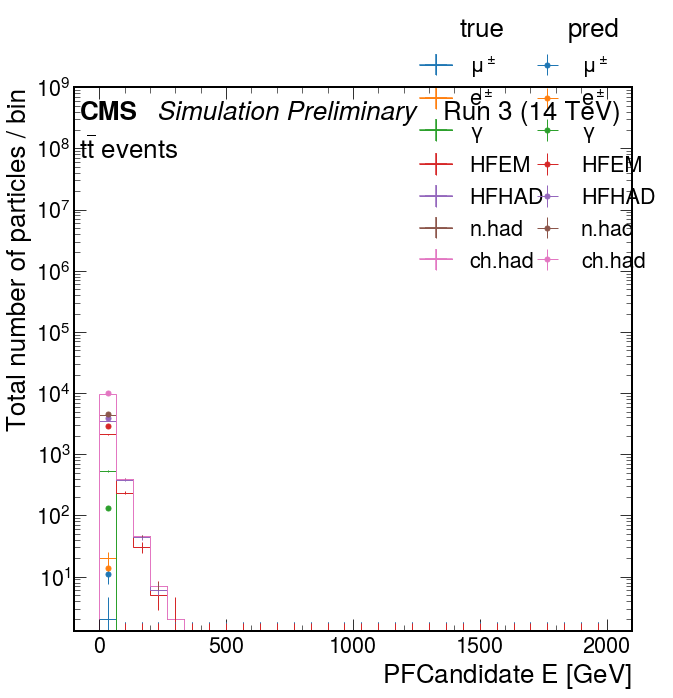

In [22]:
hists_gen = get_distribution("gen", np.linspace(0,2000,61), "energy")
hists_pred = get_distribution("pred", np.linspace(0,2000,61), "energy")

ax = plt.axes()
v1 = mplhep.histplot([h[bh.rebin(2)] for h in hists_gen], stack=True, label=[class_names[k] for k in [13,11,22,1,2,130,211]], lw=1)
v2 = mplhep.histplot([h[bh.rebin(2)] for h in hists_pred], stack=True, color=[x.stairs.get_edgecolor() for x in v1], lw=2, histtype="errorbar")

legend1 = plt.legend(v1, [x.legend_artist.get_label() for x in v1], loc=(0.60, 0.64), title="true")
legend2 = plt.legend(v2, [x.legend_artist.get_label() for x in v1], loc=(0.8, 0.64), title="pred")
plt.gca().add_artist(legend1)
plt.ylabel("Total number of particles / bin")
cms_label(ax)
sample_label(ax)

plt.yscale("log")
plt.ylim(top=1e9)
plt.xlabel("PFCandidate $E$ [GeV]")

plt.savefig("energy_true_vs_pred.pdf", bbox_inches="tight")

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale
/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale
/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale
/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale
/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: invalid value encountered in true_divide
  counts = sumw / scale
/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_

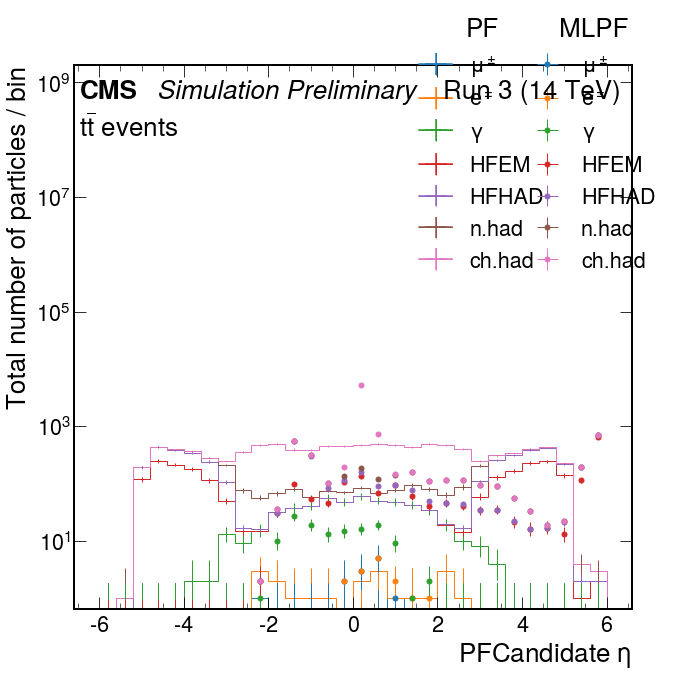

In [23]:
hists_true = get_distribution("gen", np.linspace(-6,6,61), "eta")
hists_pred = get_distribution("pred", np.linspace(-6,6,61), "eta")

ax = plt.axes()
v1 = mplhep.histplot([h[bh.rebin(2)] for h in hists_true], stack=True, label=[class_names[k] for k in [13,11,22,1,2,130,211]], lw=1)
v2 = mplhep.histplot([h[bh.rebin(2)] for h in hists_pred], stack=True, color=[x.stairs.get_edgecolor() for x in v1], lw=2, histtype="errorbar")

legend1 = plt.legend(v1, [x.legend_artist.get_label() for x in v1], loc=(0.60, 0.6), title="PF")
legend2 = plt.legend(v2, [x.legend_artist.get_label() for x in v1], loc=(0.8, 0.6), title="MLPF")
plt.gca().add_artist(legend1)
plt.ylabel("Total number of particles / bin")
cms_label(ax)
sample_label(ax)

plt.yscale("log")
plt.ylim(top=2e9)
plt.xlabel("PFCandidate $\eta$")
plt.savefig("eta_true_vs_pred.pdf", bbox_inches="tight")

In [24]:
def plot_elem_energy_cls_prob(elem_type):
    plt.figure(figsize=(4*5,2*4))
    plt.suptitle("PFElement type {}".format(elem_type))
    
    for icls in range(8):
        plt.subplot(2,4,icls+1)
        plt.hist2d(
            np.log10(X_f[X_f[:, 0]==elem_type, 4]),
            ypred_raw_f[X_f[:, 0]==elem_type, icls],
            bins=(np.linspace(-2,4,100), np.linspace(0,1,100)), cmap="Blues");
        plt.colorbar()
        plt.xlabel("PFElement log[E/GeV]")
        plt.ylabel("MLPF probability for class {}".format(icls))
    plt.tight_layout()

In [25]:
def plot_eff_and_fake_rate(
    icls=1,
    ivar=4,
    ielem=1,
    bins=np.linspace(-3,6,100),
    xlabel="PFElement log[E/GeV]", log=True
    ):
    
    values = X_f[:, ivar]
    
    hist_gen = np.histogram(values[(yvals_f["gen_cls_id"]==icls) & (X_f[:, 0]==ielem)], bins=bins);
    hist_gen_pred = np.histogram(values[(yvals_f["gen_cls_id"]==icls) & (yvals_f["pred_cls_id"]==icls) & (X_f[:, 0]==ielem)], bins=bins);
    hist_gen_cand = np.histogram(values[(yvals_f["gen_cls_id"]==icls) & (yvals_f["cand_cls_id"]==icls) & (X_f[:, 0]==ielem)], bins=bins);

    hist_pred = np.histogram(values[(yvals_f["pred_cls_id"]==icls) & (X_f[:, 0]==ielem)], bins=bins);
    hist_cand = np.histogram(values[(yvals_f["cand_cls_id"]==icls) & (X_f[:, 0]==ielem)], bins=bins);
    hist_pred_fake = np.histogram(values[(yvals_f["gen_cls_id"]!=icls) & (yvals_f["pred_cls_id"]==icls) & (X_f[:, 0]==ielem)], bins=bins);
    hist_cand_fake = np.histogram(values[(yvals_f["gen_cls_id"]!=icls) & (yvals_f["cand_cls_id"]==icls) & (X_f[:, 0]==ielem)], bins=bins);

    eff_mlpf = hist_gen_pred[0]/hist_gen[0]
    eff_pf = hist_gen_cand[0]/hist_gen[0]
    fake_pf = hist_cand_fake[0]/hist_cand[0]
    fake_mlpf = hist_pred_fake[0]/hist_pred[0]

    plt.figure()
    ax = plt.axes()
    mplhep.histplot(hist_gen, label="Gen", color="black")
    mplhep.histplot(hist_cand, label="PF")
    mplhep.histplot(hist_pred, label="MLPF")
    plt.ylabel("Number of PFElements / bin")
    plt.xlabel(xlabel)
    cms_label(ax)
    sample_label(ax, ", " + CLASS_NAMES_CMS[icls])
    if log:
        plt.xscale("log")
    plt.savefig("distr_icls{}_ivar{}.pdf".format(icls, ivar), bbox_inches="tight")
        
    plt.figure()
    ax = plt.axes(sharex=ax)
    mplhep.histplot(eff_pf, bins=hist_gen[1], label="PF")
    mplhep.histplot(eff_mlpf, bins=hist_gen[1], label="MLFP")
    plt.ylim(0,1.2)
    plt.ylabel("Efficiency")
    plt.xlabel(xlabel)
    cms_label(ax)
    sample_label(ax, ", " + CLASS_NAMES_CMS[icls])
    if log:
        plt.xscale("log")
    plt.savefig("eff_icls{}_ivar{}.pdf".format(icls, ivar), bbox_inches="tight")

    plt.figure()
    ax = plt.axes(sharex=ax)
    mplhep.histplot(fake_pf, bins=hist_gen[1], label="PF")
    mplhep.histplot(fake_mlpf, bins=hist_gen[1], label="PF")
    plt.ylim(0,1.2)
    plt.ylabel("Fake rate")
    plt.xlabel(xlabel)
    cms_label(ax)
    sample_label(ax, ", " + CLASS_NAMES_CMS[icls])
    if log:
        plt.xscale("log")
    plt.savefig("fake_icls{}_ivar{}.pdf".format(icls, ivar), bbox_inches="tight")

    #mplhep.histplot(fake, bins=hist_gen[1], label="fake rate", color="red")
#     plt.legend(frameon=False)
#     plt.ylim(0,1.4)
#     plt.xlabel(xlabel)
#     plt.ylabel("Fraction of particles / bin")
    


<ipython-input-15-e840ccdc627f>:20: RuntimeWarning: invalid value encountered in true_divide
  eff_mlpf = hist_gen_pred[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:21: RuntimeWarning: invalid value encountered in true_divide
  eff_pf = hist_gen_cand[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:22: RuntimeWarning: invalid value encountered in true_divide
  fake_pf = hist_cand_fake[0]/hist_cand[0]
<ipython-input-15-e840ccdc627f>:23: RuntimeWarning: invalid value encountered in true_divide
  fake_mlpf = hist_pred_fake[0]/hist_pred[0]


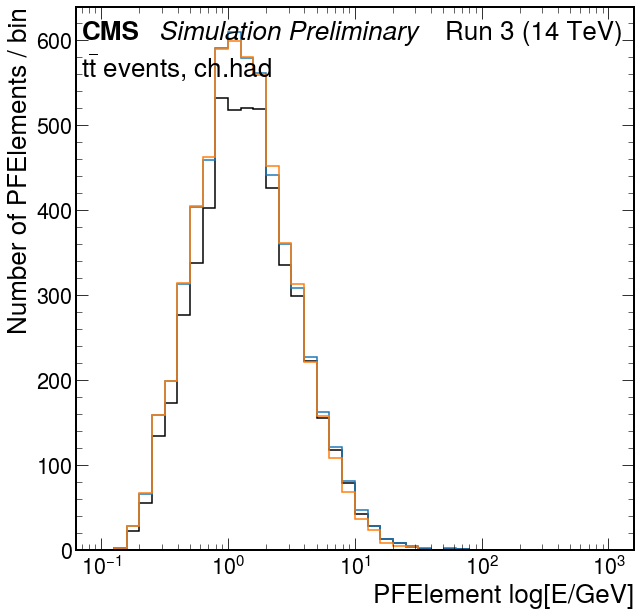

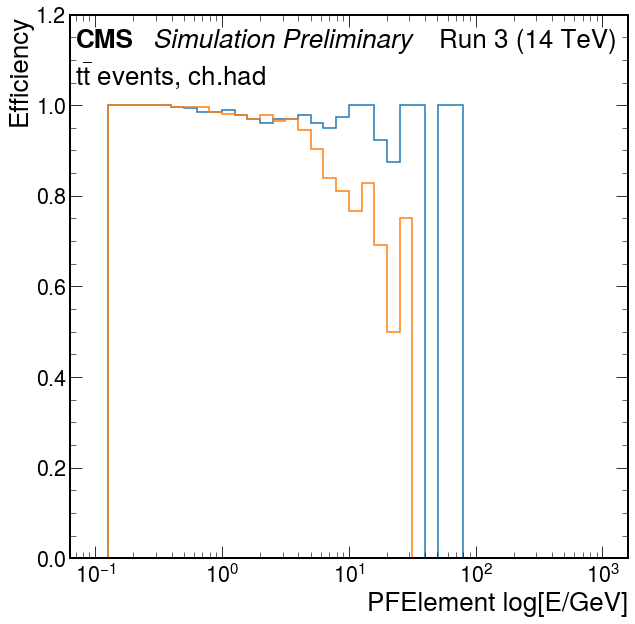

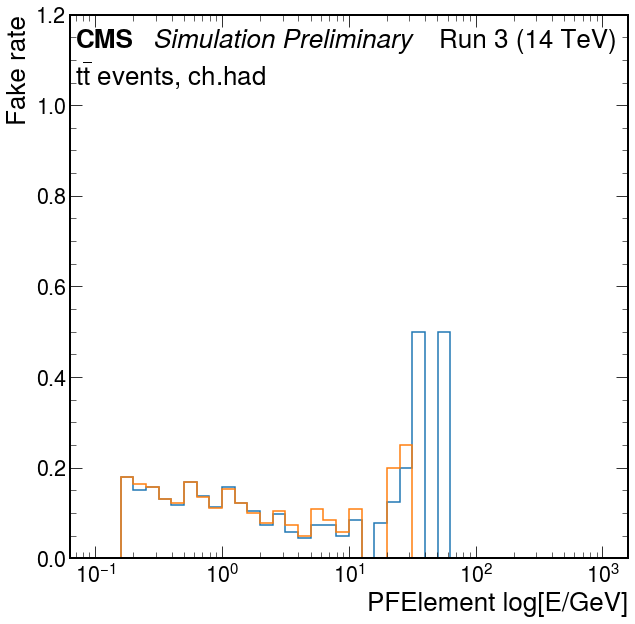

In [16]:
plot_eff_and_fake_rate(icls=1, ivar=4, ielem=1, bins=np.logspace(-1, 3, 41), log=True)

<ipython-input-15-e840ccdc627f>:20: RuntimeWarning: invalid value encountered in true_divide
  eff_mlpf = hist_gen_pred[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:21: RuntimeWarning: invalid value encountered in true_divide
  eff_pf = hist_gen_cand[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:22: RuntimeWarning: invalid value encountered in true_divide
  fake_pf = hist_cand_fake[0]/hist_cand[0]
<ipython-input-15-e840ccdc627f>:23: RuntimeWarning: invalid value encountered in true_divide
  fake_mlpf = hist_pred_fake[0]/hist_pred[0]


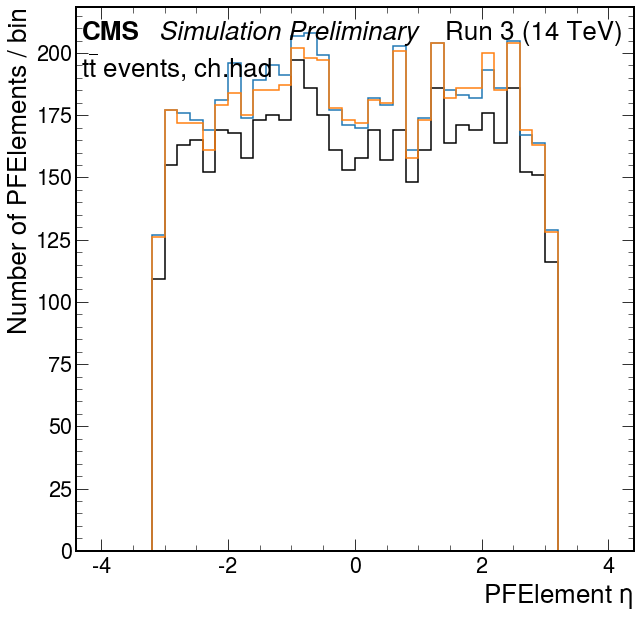

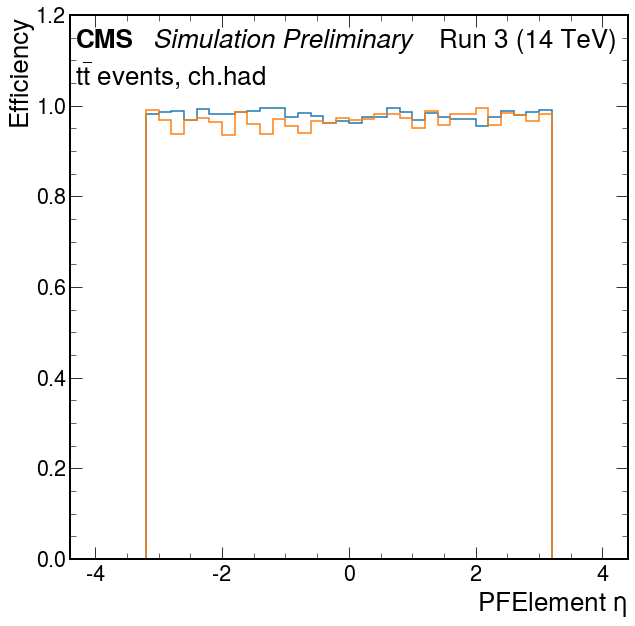

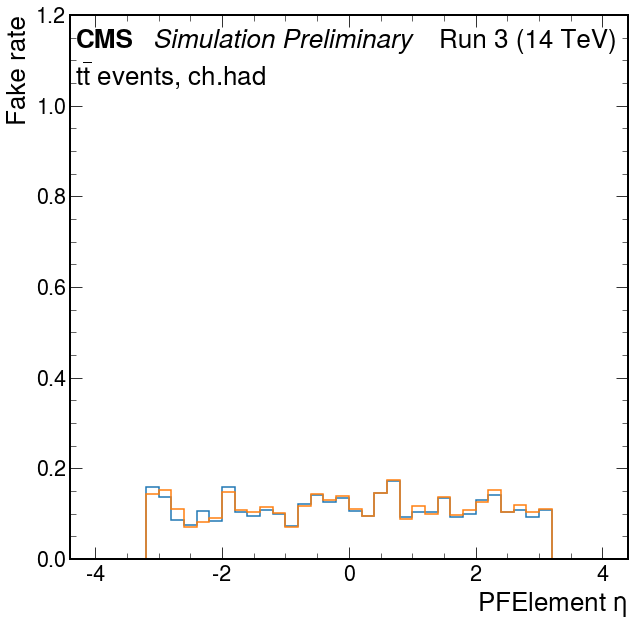

In [17]:
plot_eff_and_fake_rate(icls=1, ivar=3, ielem=1, bins=np.linspace(-4, 4, 41), log=False, xlabel="PFElement $\eta$")

<ipython-input-15-e840ccdc627f>:20: RuntimeWarning: invalid value encountered in true_divide
  eff_mlpf = hist_gen_pred[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:21: RuntimeWarning: invalid value encountered in true_divide
  eff_pf = hist_gen_cand[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:22: RuntimeWarning: invalid value encountered in true_divide
  fake_pf = hist_cand_fake[0]/hist_cand[0]
<ipython-input-15-e840ccdc627f>:23: RuntimeWarning: invalid value encountered in true_divide
  fake_mlpf = hist_pred_fake[0]/hist_pred[0]


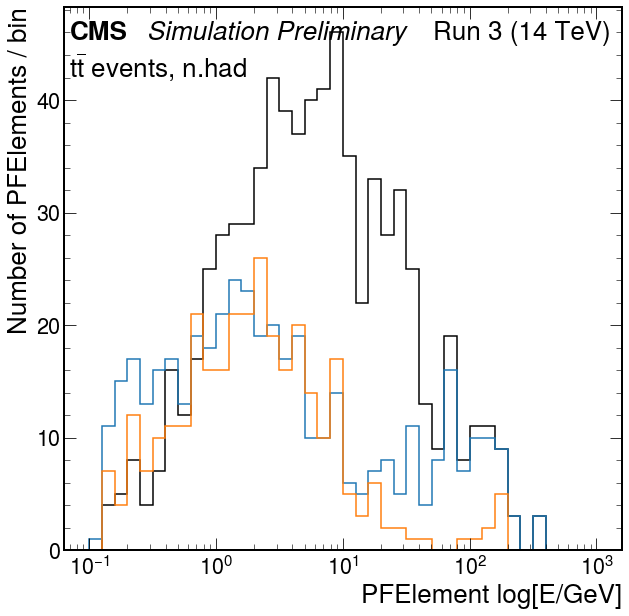

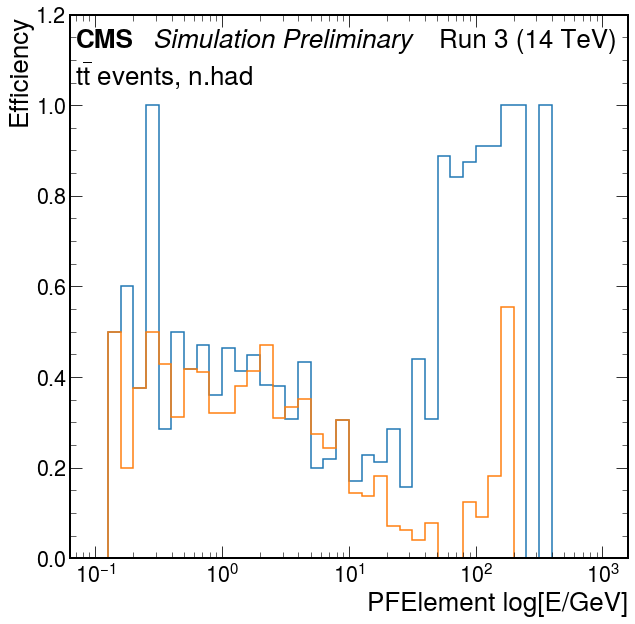

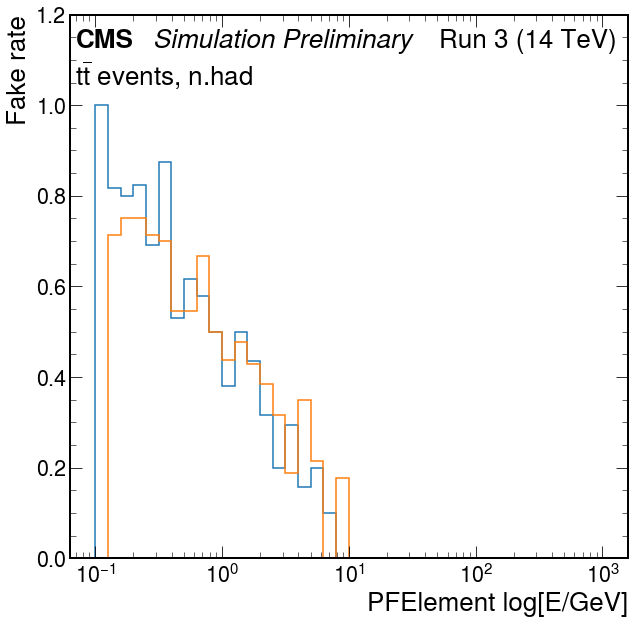

In [18]:
plot_eff_and_fake_rate(icls=2, ivar=4, ielem=5, bins=np.logspace(-1, 3, 41), log=True)

<ipython-input-15-e840ccdc627f>:20: RuntimeWarning: invalid value encountered in true_divide
  eff_mlpf = hist_gen_pred[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:21: RuntimeWarning: invalid value encountered in true_divide
  eff_pf = hist_gen_cand[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:22: RuntimeWarning: invalid value encountered in true_divide
  fake_pf = hist_cand_fake[0]/hist_cand[0]
<ipython-input-15-e840ccdc627f>:23: RuntimeWarning: invalid value encountered in true_divide
  fake_mlpf = hist_pred_fake[0]/hist_pred[0]


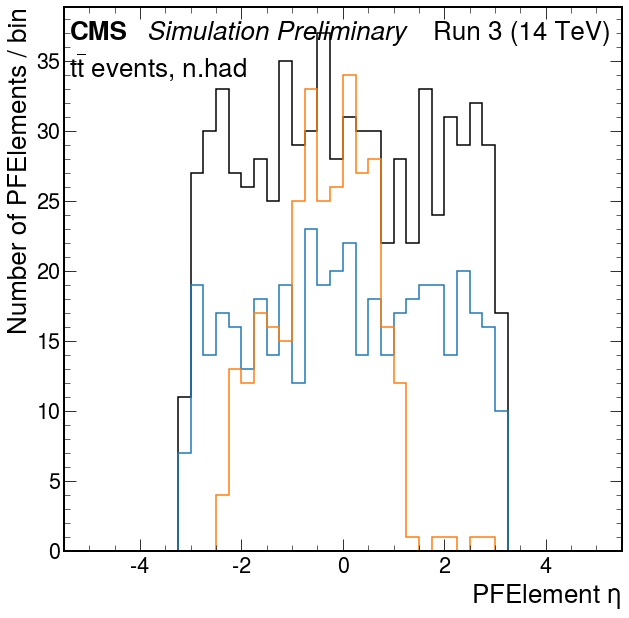

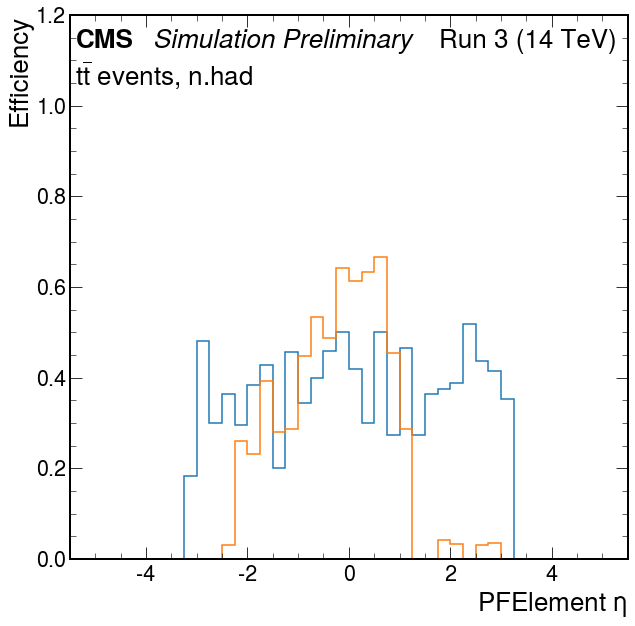

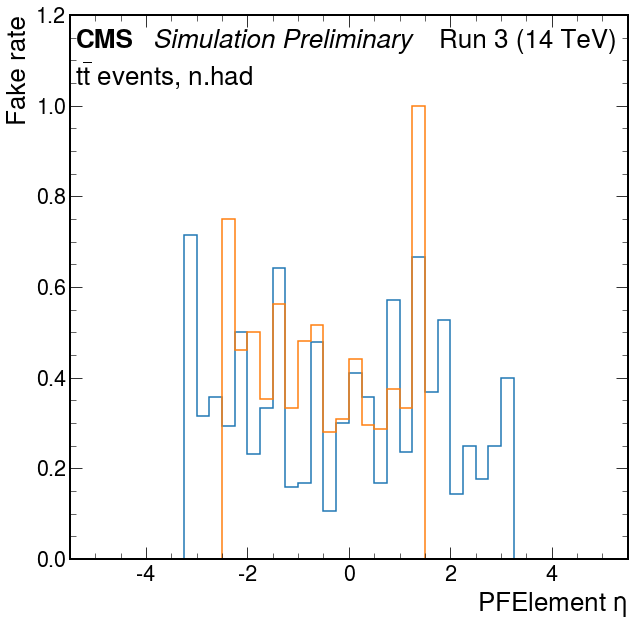

In [19]:
plot_eff_and_fake_rate(icls=2, ivar=3, ielem=5, bins=np.linspace(-5, 5, 41), log=False, xlabel="PFElement $\eta$")

<ipython-input-15-e840ccdc627f>:20: RuntimeWarning: invalid value encountered in true_divide
  eff_mlpf = hist_gen_pred[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:21: RuntimeWarning: invalid value encountered in true_divide
  eff_pf = hist_gen_cand[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:22: RuntimeWarning: invalid value encountered in true_divide
  fake_pf = hist_cand_fake[0]/hist_cand[0]
<ipython-input-15-e840ccdc627f>:23: RuntimeWarning: invalid value encountered in true_divide
  fake_mlpf = hist_pred_fake[0]/hist_pred[0]


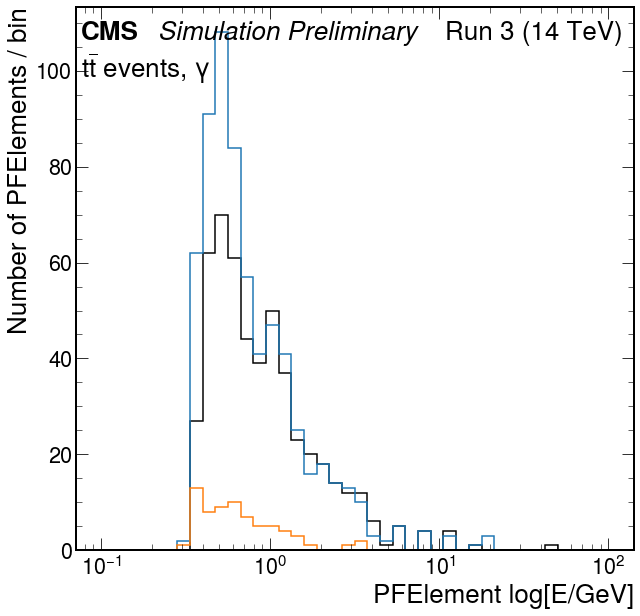

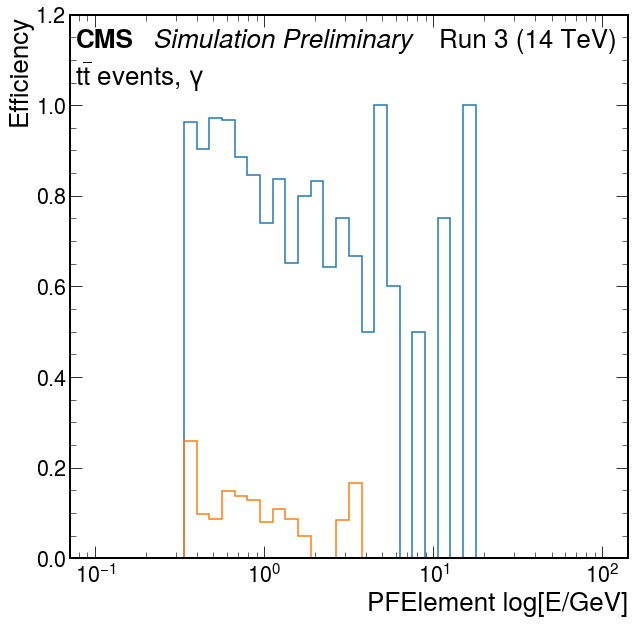

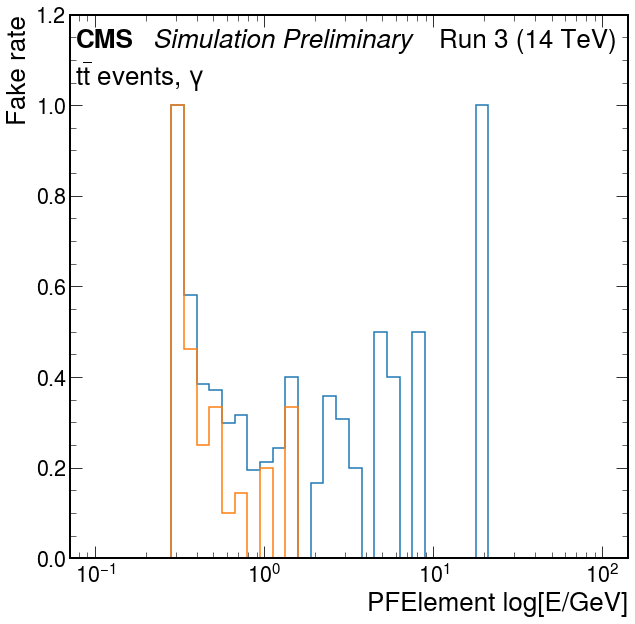

In [20]:
plot_eff_and_fake_rate(icls=5, ivar=4, ielem=4, bins=np.logspace(-1, 2, 41), log=True)

<ipython-input-15-e840ccdc627f>:20: RuntimeWarning: invalid value encountered in true_divide
  eff_mlpf = hist_gen_pred[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:21: RuntimeWarning: invalid value encountered in true_divide
  eff_pf = hist_gen_cand[0]/hist_gen[0]
<ipython-input-15-e840ccdc627f>:22: RuntimeWarning: invalid value encountered in true_divide
  fake_pf = hist_cand_fake[0]/hist_cand[0]
<ipython-input-15-e840ccdc627f>:23: RuntimeWarning: invalid value encountered in true_divide
  fake_mlpf = hist_pred_fake[0]/hist_pred[0]


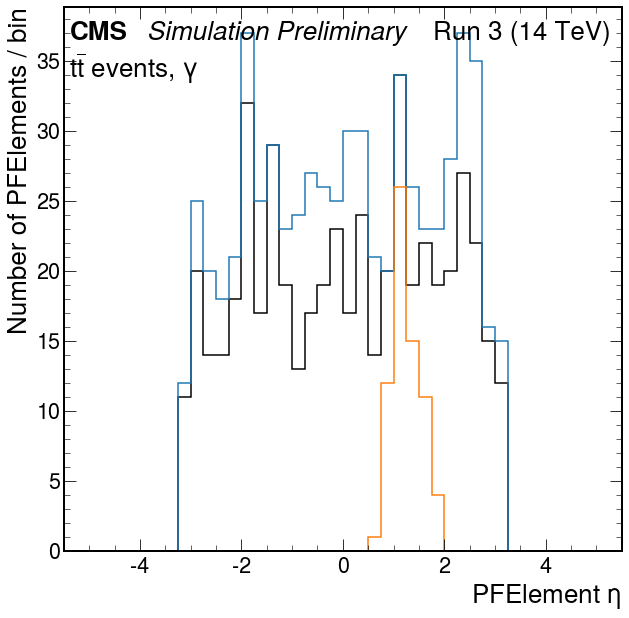

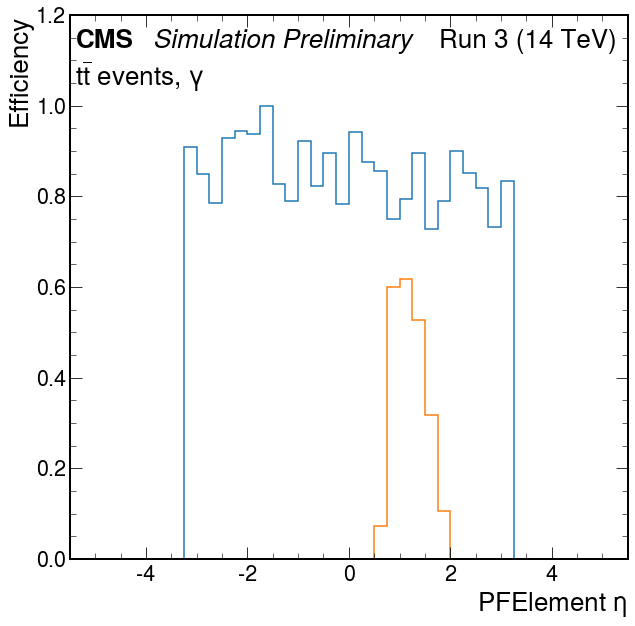

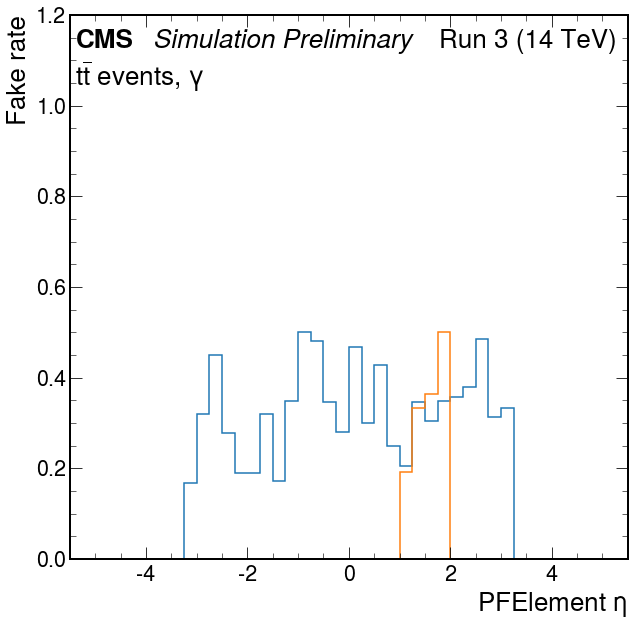

In [21]:
plot_eff_and_fake_rate(icls=5, ivar=3, ielem=4, bins=np.linspace(-5, 5, 41), log=False, xlabel="PFElement $\eta$")

<ipython-input-25-e840ccdc627f>:20: RuntimeWarning: invalid value encountered in true_divide
  eff_mlpf = hist_gen_pred[0]/hist_gen[0]
<ipython-input-25-e840ccdc627f>:21: RuntimeWarning: invalid value encountered in true_divide
  eff_pf = hist_gen_cand[0]/hist_gen[0]
<ipython-input-25-e840ccdc627f>:22: RuntimeWarning: invalid value encountered in true_divide
  fake_pf = hist_cand_fake[0]/hist_cand[0]
<ipython-input-25-e840ccdc627f>:23: RuntimeWarning: invalid value encountered in true_divide
  fake_mlpf = hist_pred_fake[0]/hist_pred[0]


TypeError: cannot unpack non-iterable NoneType object

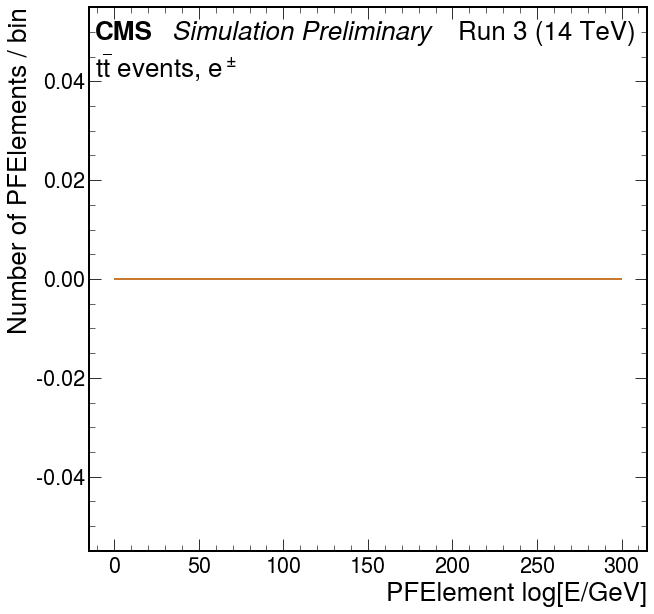

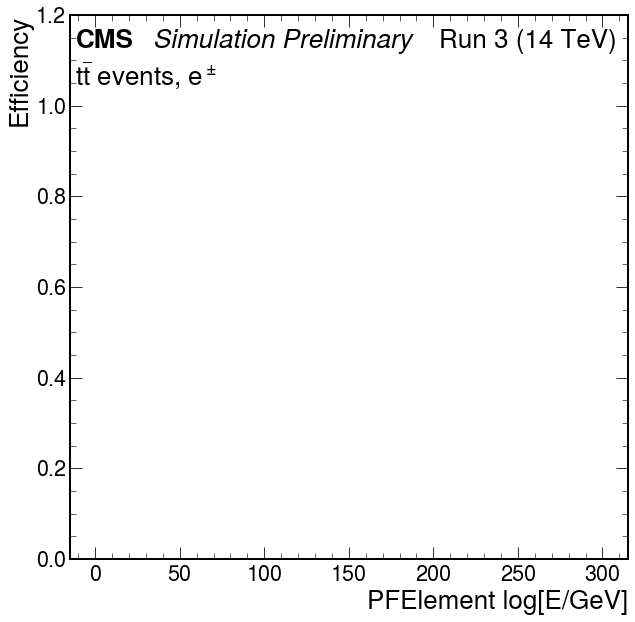

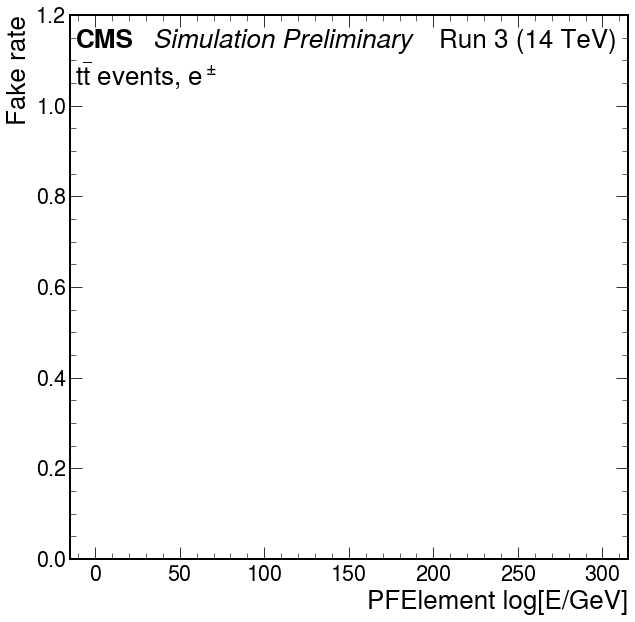

In [26]:
ax1, ax2 = plot_eff_and_fake_rate(6, ielem=4, bins=np.linspace(0, 300, 21), log=False)
ax1.set_yscale("log")
ax1.set_title("ECAL cluster, electron predictions")
plt.savefig("ecal_ele_eff_fake.pdf", bbox_inches="tight")
plt.savefig("ecal_ele_eff_fake.png", bbox_inches="tight", dpi=300)

In [ ]:
# ax1, ax2 = plot_eff_and_fake_rate(6, ielem=6, bins=np.linspace(0, 300, 21), log=False)
# ax1.set_yscale("log")
# ax1.set_title("GSF track, electron predictions")
# plt.savefig("gsf_electron_eff_fake.pdf", bbox_inches="tight")
# plt.savefig("gsf_electron_eff_fake.png", bbox_inches="tight", dpi=300)

In [ ]:
def load_history(path, max_epoch=None):
    ret = {}
    for fi in glob.glob(path):
        data = json.load(open(fi))
        epoch = int(fi.split("_")[-1].split(".")[0])
        ret[epoch] = data
    
    if not max_epoch:
        max_epoch = max(ret.keys())
    ret2 = []
    for i in range(1, max_epoch+1):
        ret2.append(ret[i])
    return pandas.DataFrame(ret2)

In [ ]:
history = load_history(path + "/../history/history_*.json")

In [ ]:
def loss_plot(train, test, margin=0.05, smoothing=False):
    fig = plt.figure()
    ax = plt.axes()
    
    alpha = 0.2 if smoothing else 1.0
    l0 = None if smoothing else "train"
    l1 = None if smoothing else "test"
    p0 = plt.plot(train, alpha=alpha, label=l0)
    p1 = plt.plot(test, alpha=alpha, label=l1)
    
    if smoothing:
        train_smooth = np.convolve(train, np.ones(5)/5, mode='valid')
        plt.plot(train_smooth, color=p0[0].get_color(), lw=2, label="train")
        test_smooth = np.convolve(test, np.ones(5)/5, mode='valid')
        plt.plot(test_smooth, color=p1[0].get_color(), lw=2, label="test")
    
    plt.ylim(test[-1]*(1.0-margin), test[-1]*(1.0+margin))
    plt.legend(loc=3, frameon=False)
    plt.xlabel("epoch")
    cms_label(ax)

In [ ]:
p0 = loss_plot(history["loss"].values, history["val_loss"].values, margin=0.02)
plt.ylabel("Total loss")
plt.savefig("loss.pdf", bbox_inches="tight")
plt.savefig("loss.png", bbox_inches="tight", dpi=300)

In [ ]:
p0 = loss_plot(history["cls_loss"].values, history["val_cls_loss"].values, margin=0.02)
plt.ylabel("Multiclassification loss")
plt.savefig("cls_loss.pdf", bbox_inches="tight")
plt.savefig("cls_loss.png", bbox_inches="tight", dpi=300)

In [ ]:
reg_loss = sum([history["{}_loss".format(l)].values for l in ["energy", "pt", "eta", "sin_phi", "cos_phi", "charge"]])
val_reg_loss = sum([history["val_{}_loss".format(l)].values for l in ["energy", "pt", "eta", "sin_phi", "cos_phi", "charge"]])
p0 = loss_plot(reg_loss, val_reg_loss, margin=0.02)
plt.ylabel("Regression loss")
plt.savefig("reg_loss.pdf", bbox_inches="tight")
plt.savefig("reg_loss.png", bbox_inches="tight", dpi=300)

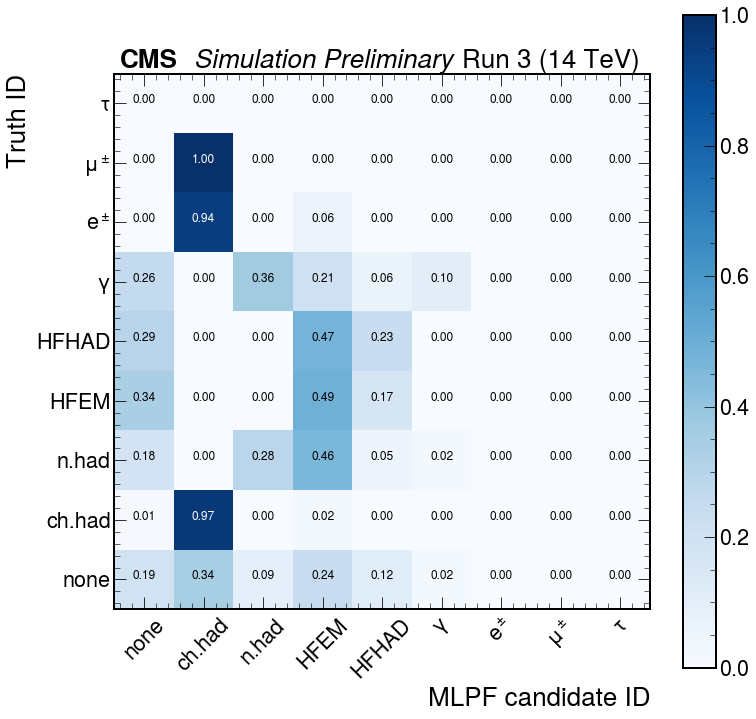

In [27]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes()

cm_norm = sklearn.metrics.confusion_matrix(
    yvals_f["gen_cls_id"][msk_X_f],
    yvals_f["pred_cls_id"][msk_X_f],
    labels=range(0,len(CLASS_LABELS_CMS)),
    normalize="true"
)

plt.imshow(cm_norm, cmap="Blues", origin="lower")
plt.colorbar()


thresh = cm_norm.max() / 1.5
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(j, i, "{:0.2f}".format(cm_norm[i, j]),
             horizontalalignment="center",
             color="white" if cm_norm[i, j] > thresh else "black", fontsize=12)

cms_label(ax, y=1.01)
#cms_label_sample_label(x1=0.18, x2=0.52, y=0.82)
plt.xticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS, rotation=45);
plt.yticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS);
plt.xlabel("MLPF candidate ID")
plt.ylabel("Truth ID")
#plt.ylim(-0.5, 6.9)
#plt.title("MLPF trained on PF")
plt.savefig("cm_normed.pdf", bbox_inches="tight")
plt.savefig("cm_normed.png", bbox_inches="tight", dpi=300)

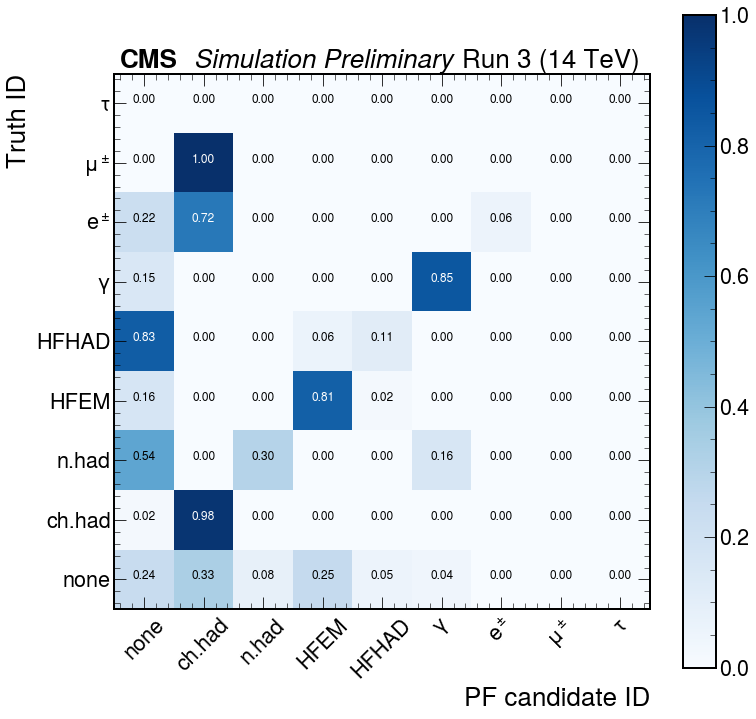

In [28]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes()

cm_norm = sklearn.metrics.confusion_matrix(
    yvals_f["gen_cls_id"][msk_X_f],
    yvals_f["cand_cls_id"][msk_X_f],
    labels=range(0,len(CLASS_LABELS_CMS)),
    normalize="true"
)

plt.imshow(cm_norm, cmap="Blues", origin="lower")
plt.colorbar()


thresh = cm_norm.max() / 1.5
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(j, i, "{:0.2f}".format(cm_norm[i, j]),
             horizontalalignment="center",
             color="white" if cm_norm[i, j] > thresh else "black", fontsize=12)

cms_label(ax, y=1.01)
#cms_label_sample_label(x1=0.18, x2=0.52, y=0.82)
plt.xticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS, rotation=45);
plt.yticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS);
plt.xlabel("PF candidate ID")
plt.ylabel("Truth ID")
#plt.ylim(-0.5, 6.9)
#plt.title("MLPF trained on PF")
plt.savefig("cm_normed_pf.pdf", bbox_inches="tight")
plt.savefig("cm_normed_pf.png", bbox_inches="tight", dpi=300)

In [ ]:
# cm = sklearn.metrics.confusion_matrix(
#     X_f[:, 0][msk_X_f],
#     yvals_f["gen_cls_id"][msk_X_f],
#     labels=range(0,12),
# )
# plt.imshow(cm, cmap="Blues", norm=matplotlib.colors.LogNorm(), origin="lower")
# plt.xticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS, rotation=45)
# plt.yticks(range(len(ELEM_NAMES_CMS)), ELEM_NAMES_CMS)
# plt.xlim(-0.5, len(CLASS_NAMES_CMS)-0.5)
# plt.ylim(0.5, len(ELEM_NAMES_CMS)-0.5)
# plt.title("Truth")

In [ ]:
# cm = sklearn.metrics.confusion_matrix(
#     X_f[:, 0][msk_X_f],
#     yvals_f["cand_cls_id"][msk_X_f],
#     labels=range(0,12),
# )
# plt.imshow(cm, cmap="Blues", norm=matplotlib.colors.LogNorm(), origin="lower")
# plt.xticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS, rotation=45)
# plt.yticks(range(len(ELEM_NAMES_CMS)), ELEM_NAMES_CMS)
# plt.xlim(-0.5, len(CLASS_NAMES_CMS)-0.5)
# plt.title("PF")

In [ ]:
# cm = sklearn.metrics.confusion_matrix(
#     X_f[:, 0][msk_X_f],
#     yvals_f["pred_cls_id"][msk_X_f],
#     labels=range(0,12),
# )
# plt.imshow(cm, cmap="Blues", norm=matplotlib.colors.LogNorm(), origin="lower")
# plt.xticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS, rotation=45)
# plt.yticks(range(len(ELEM_NAMES_CMS)), ELEM_NAMES_CMS)
# plt.xlim(-0.5, len(CLASS_NAMES_CMS)-0.5)
# plt.title("MLPF")

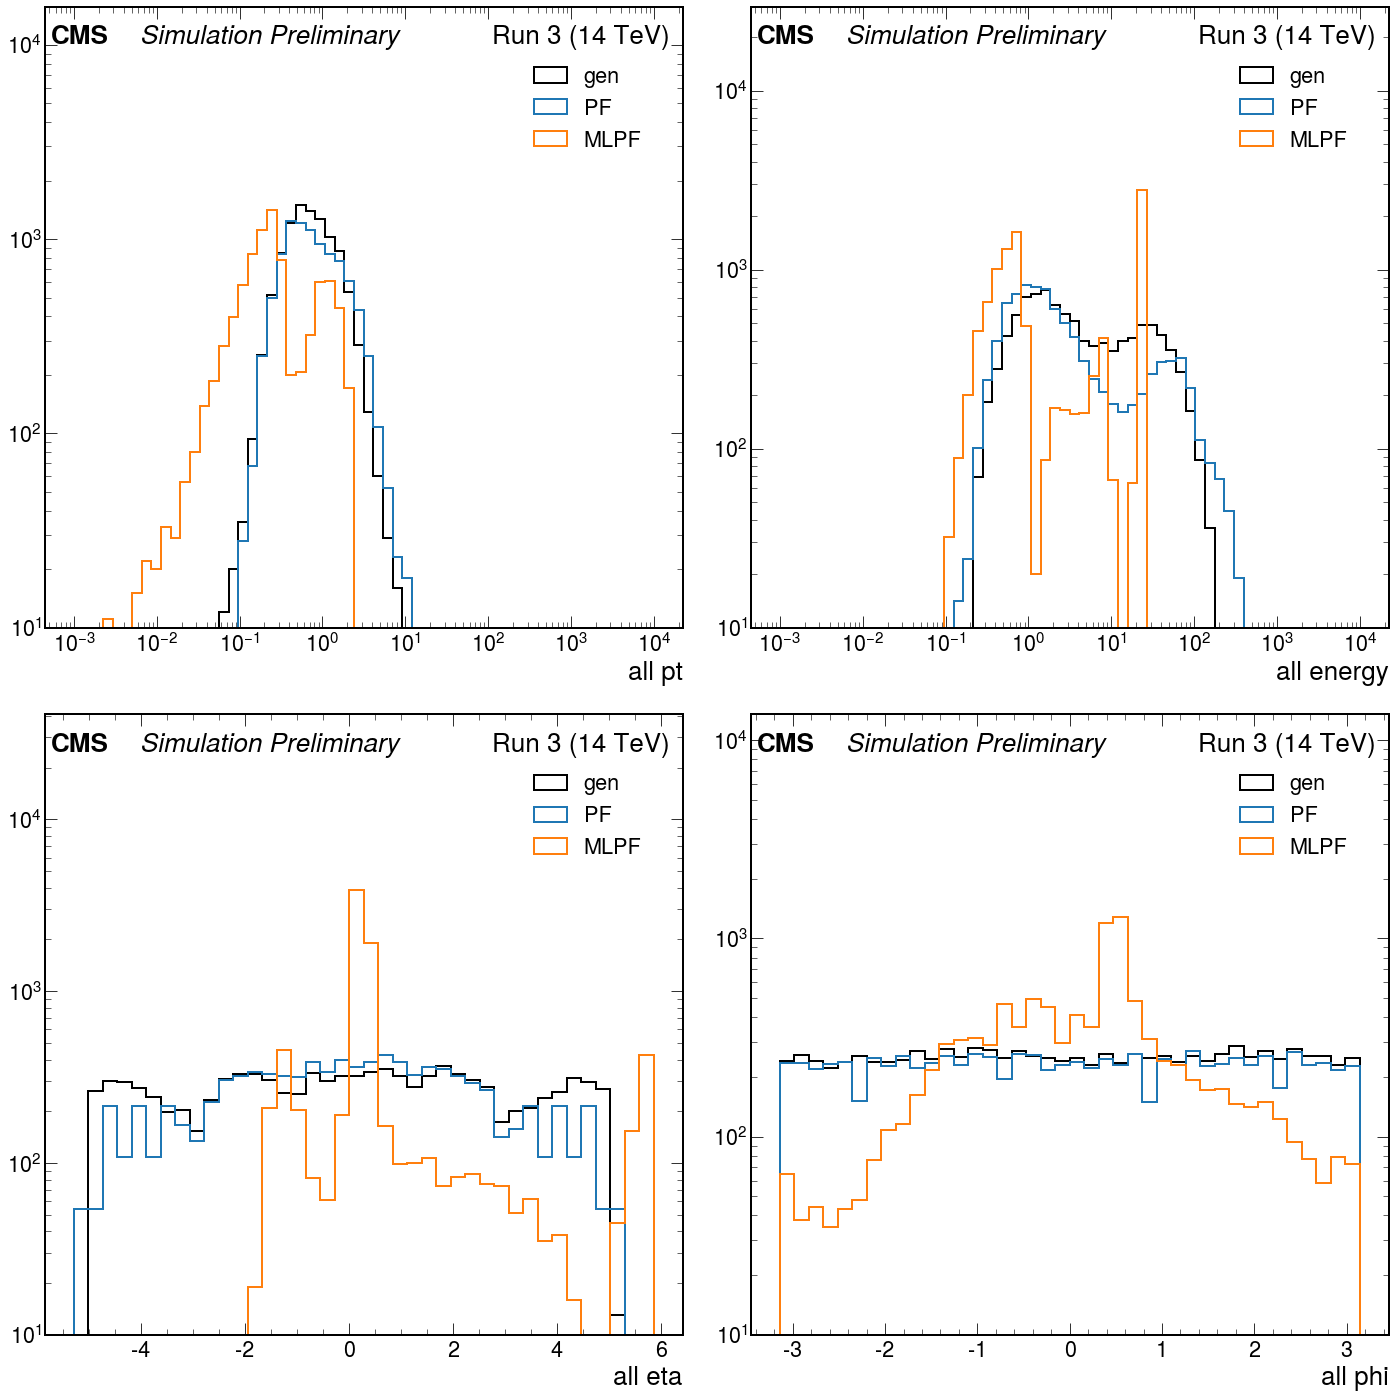

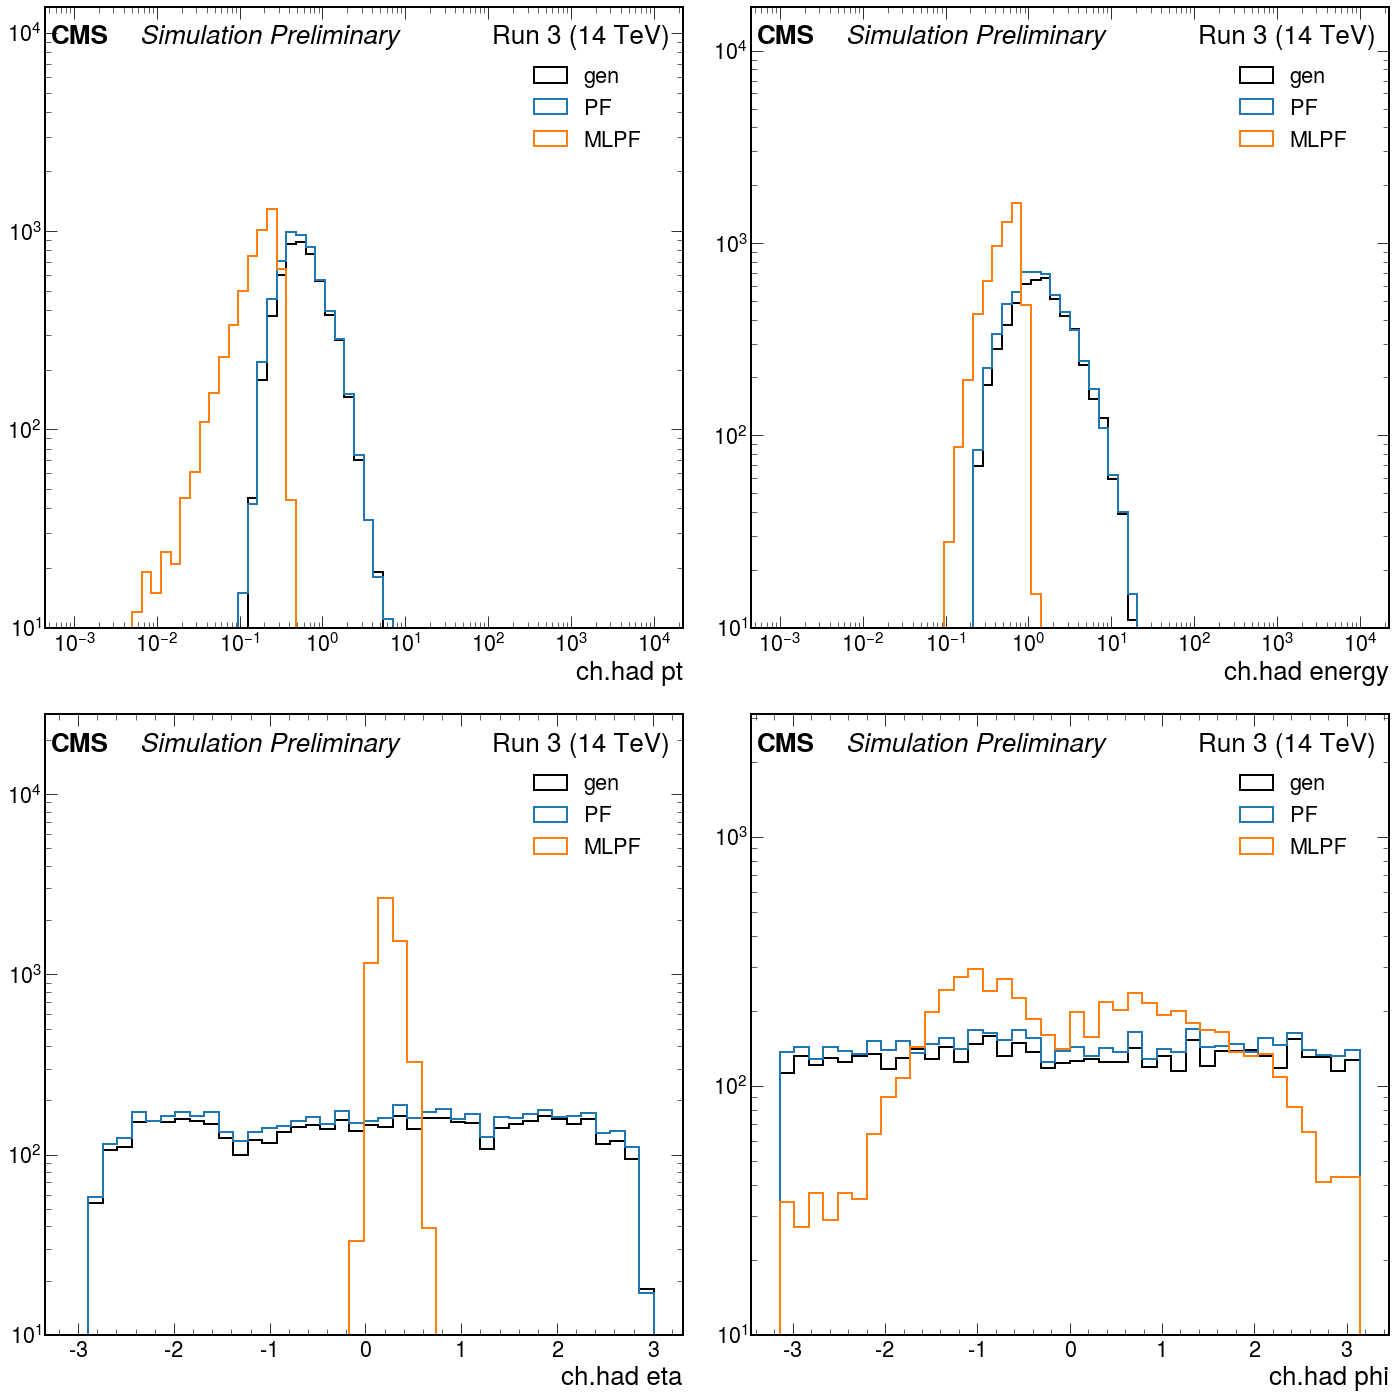

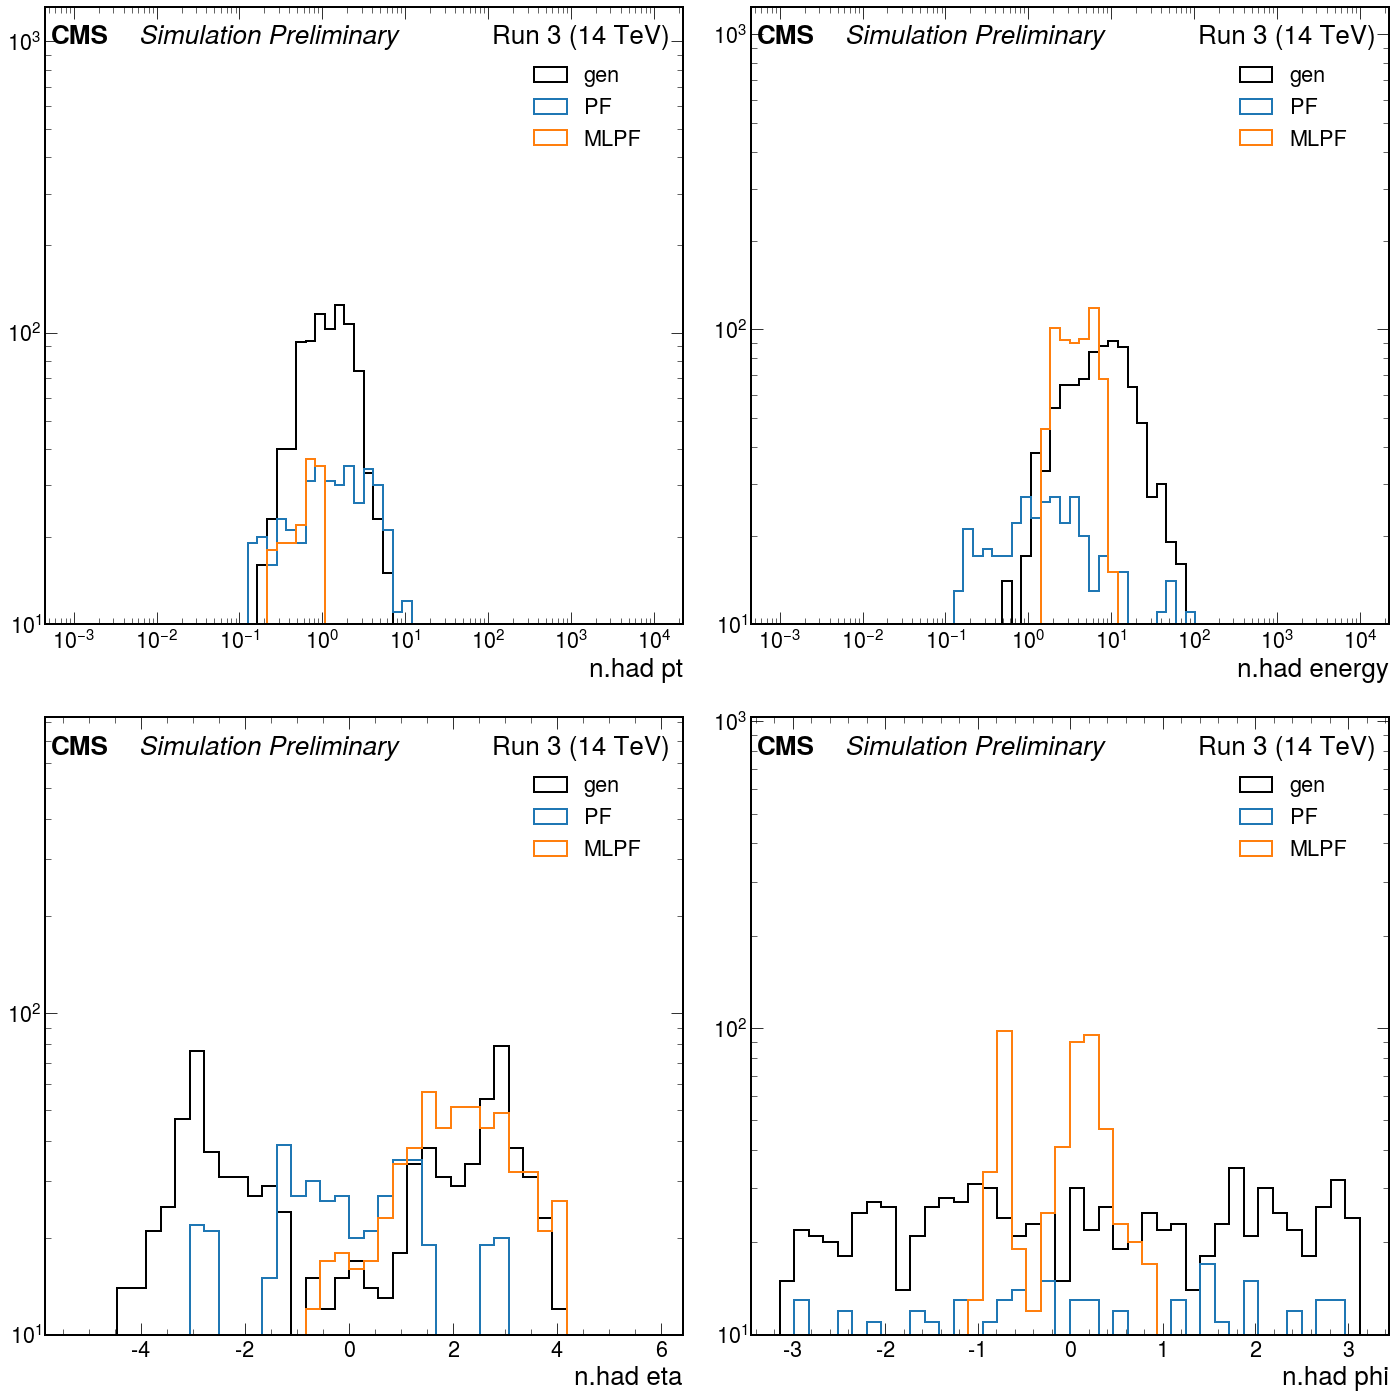

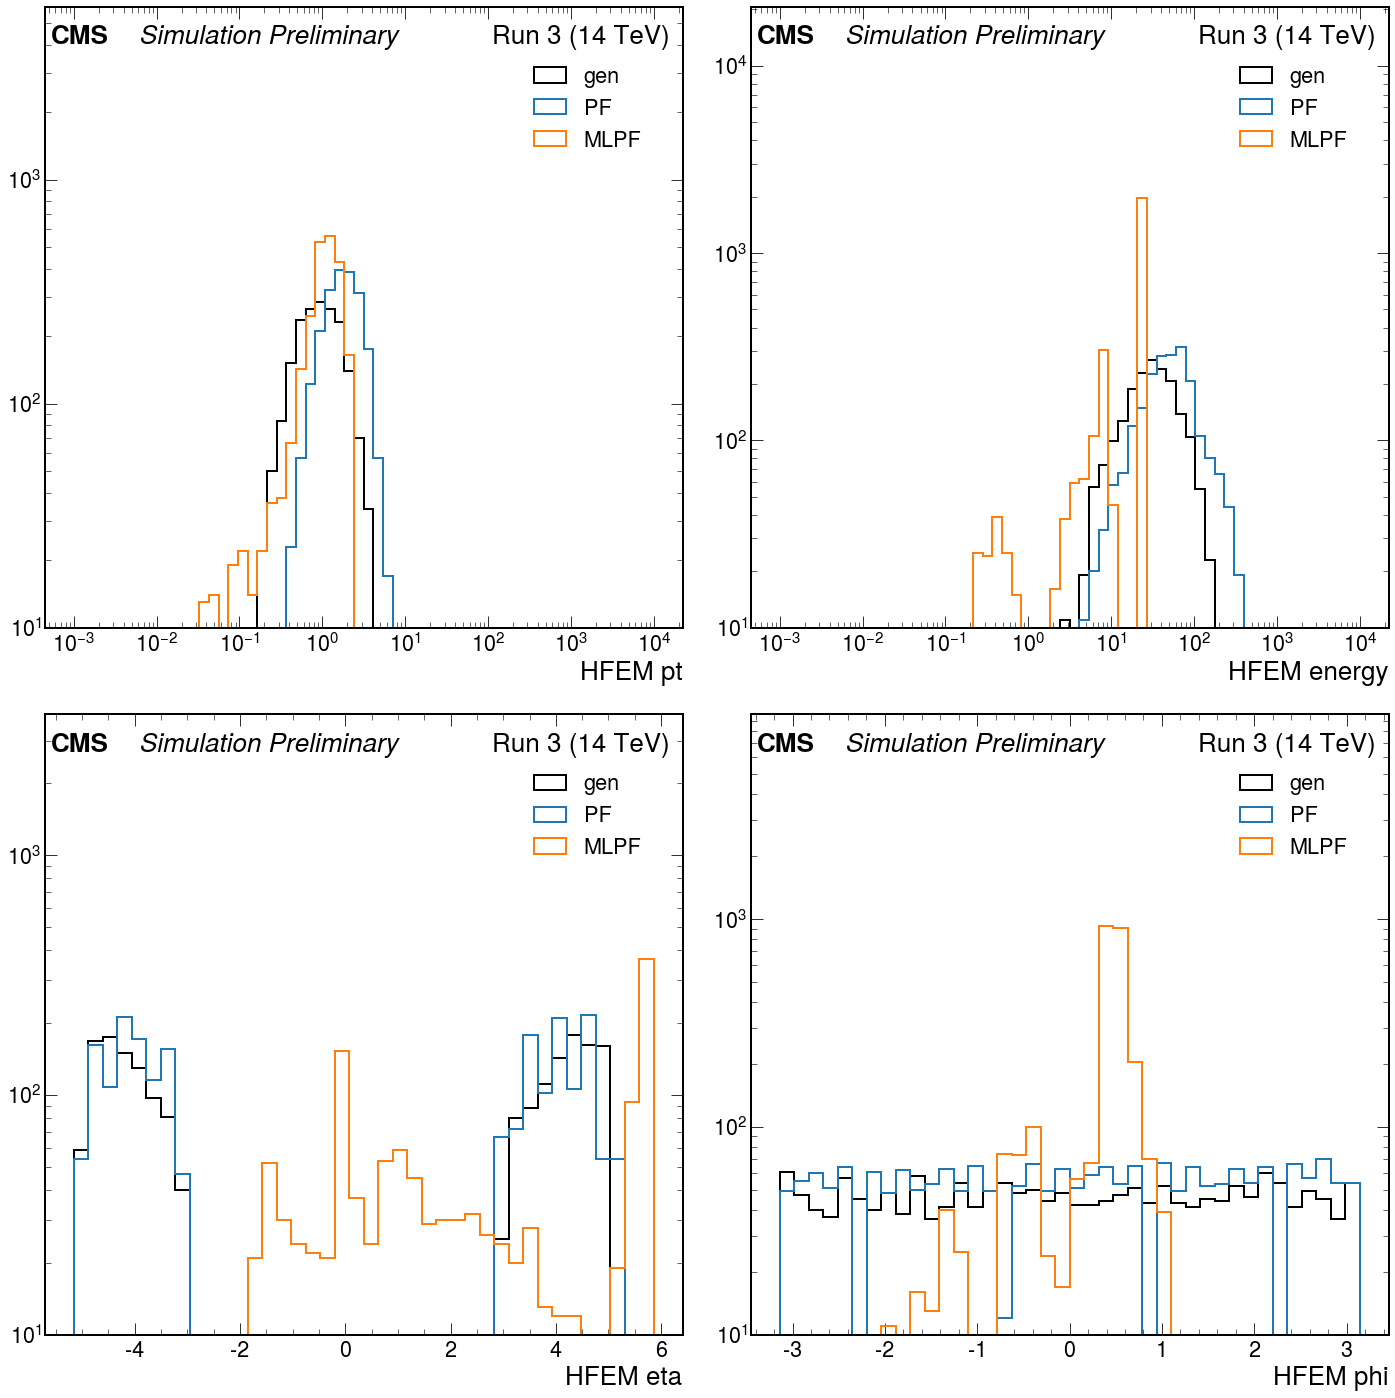

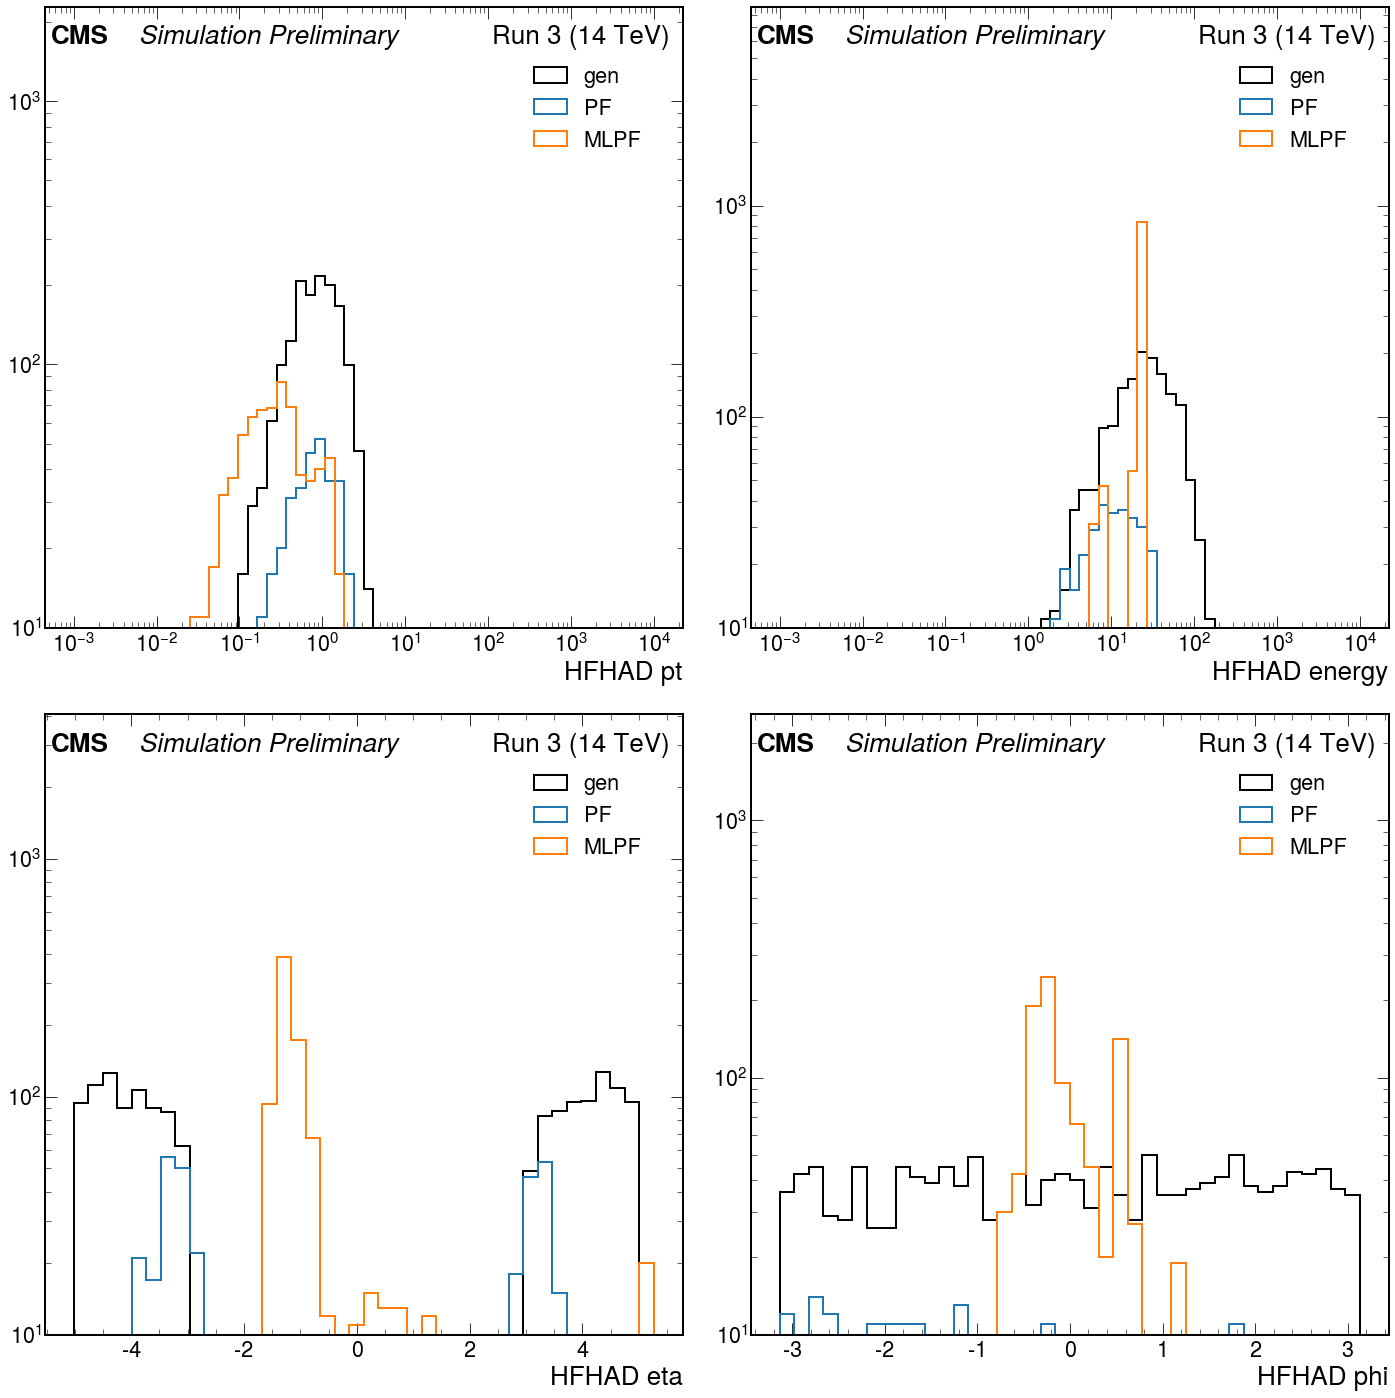

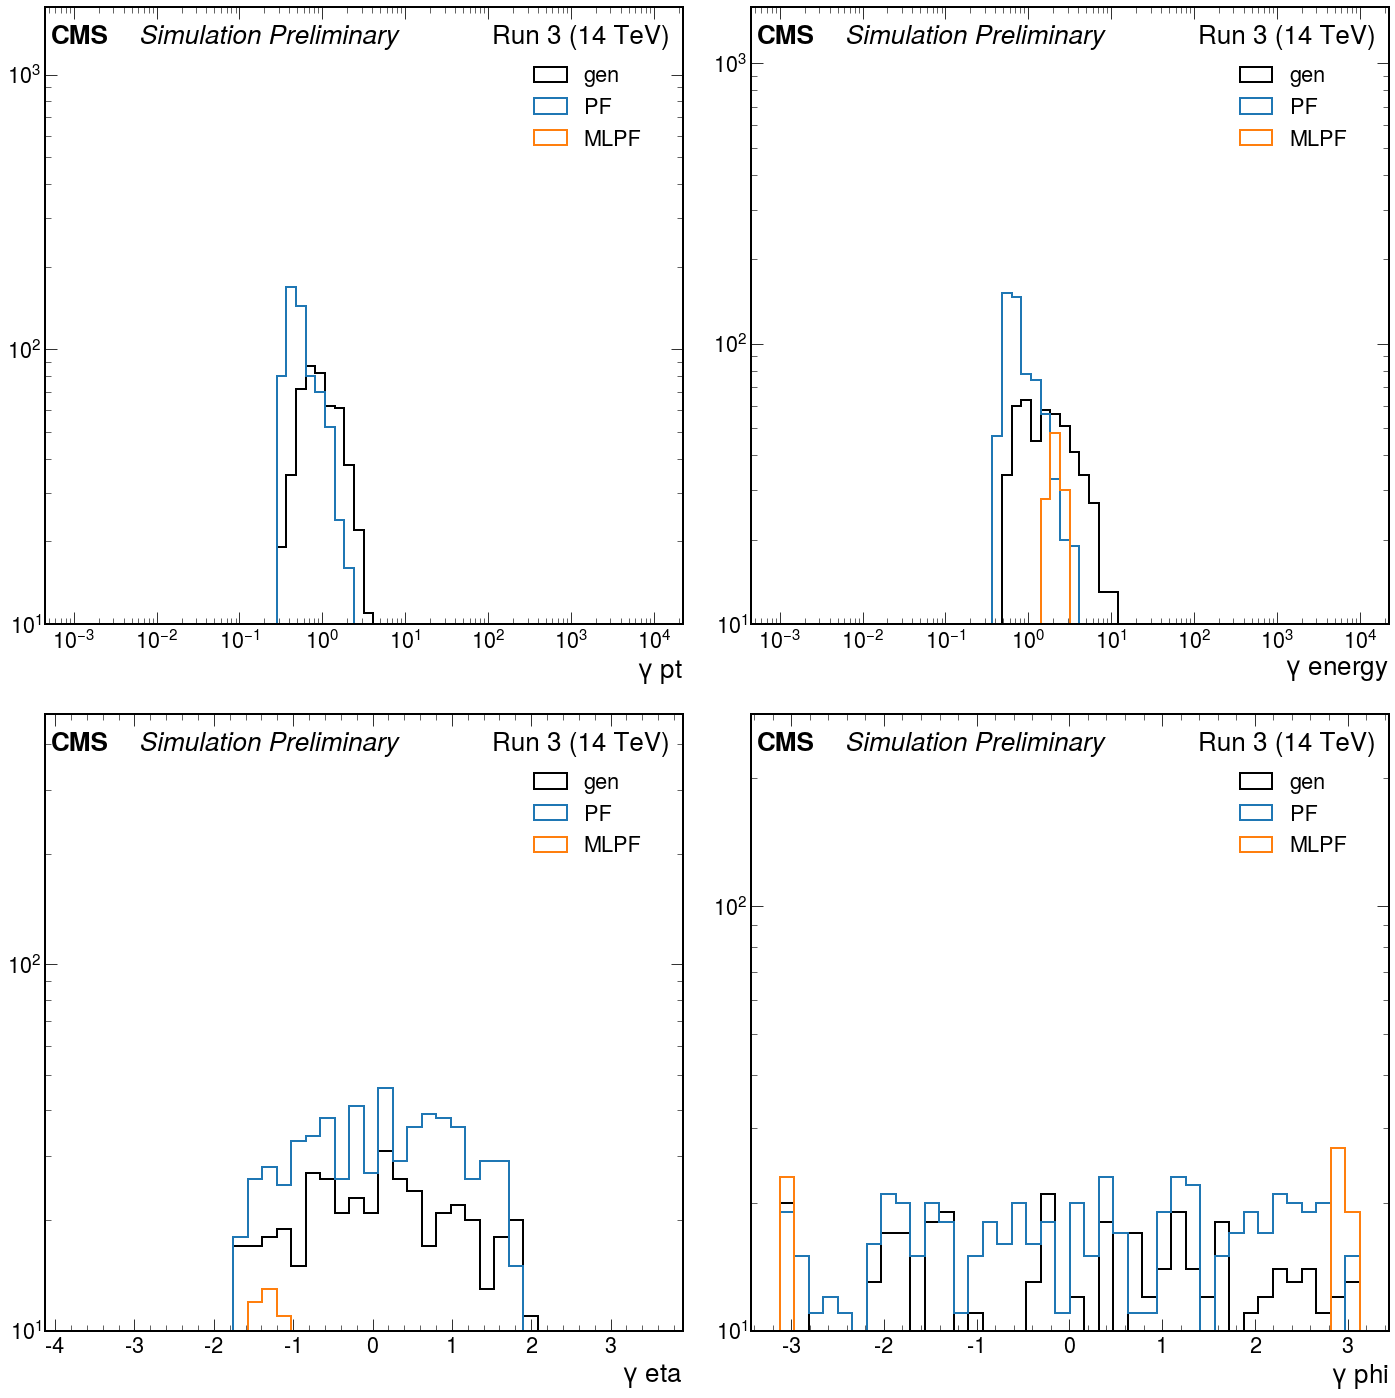

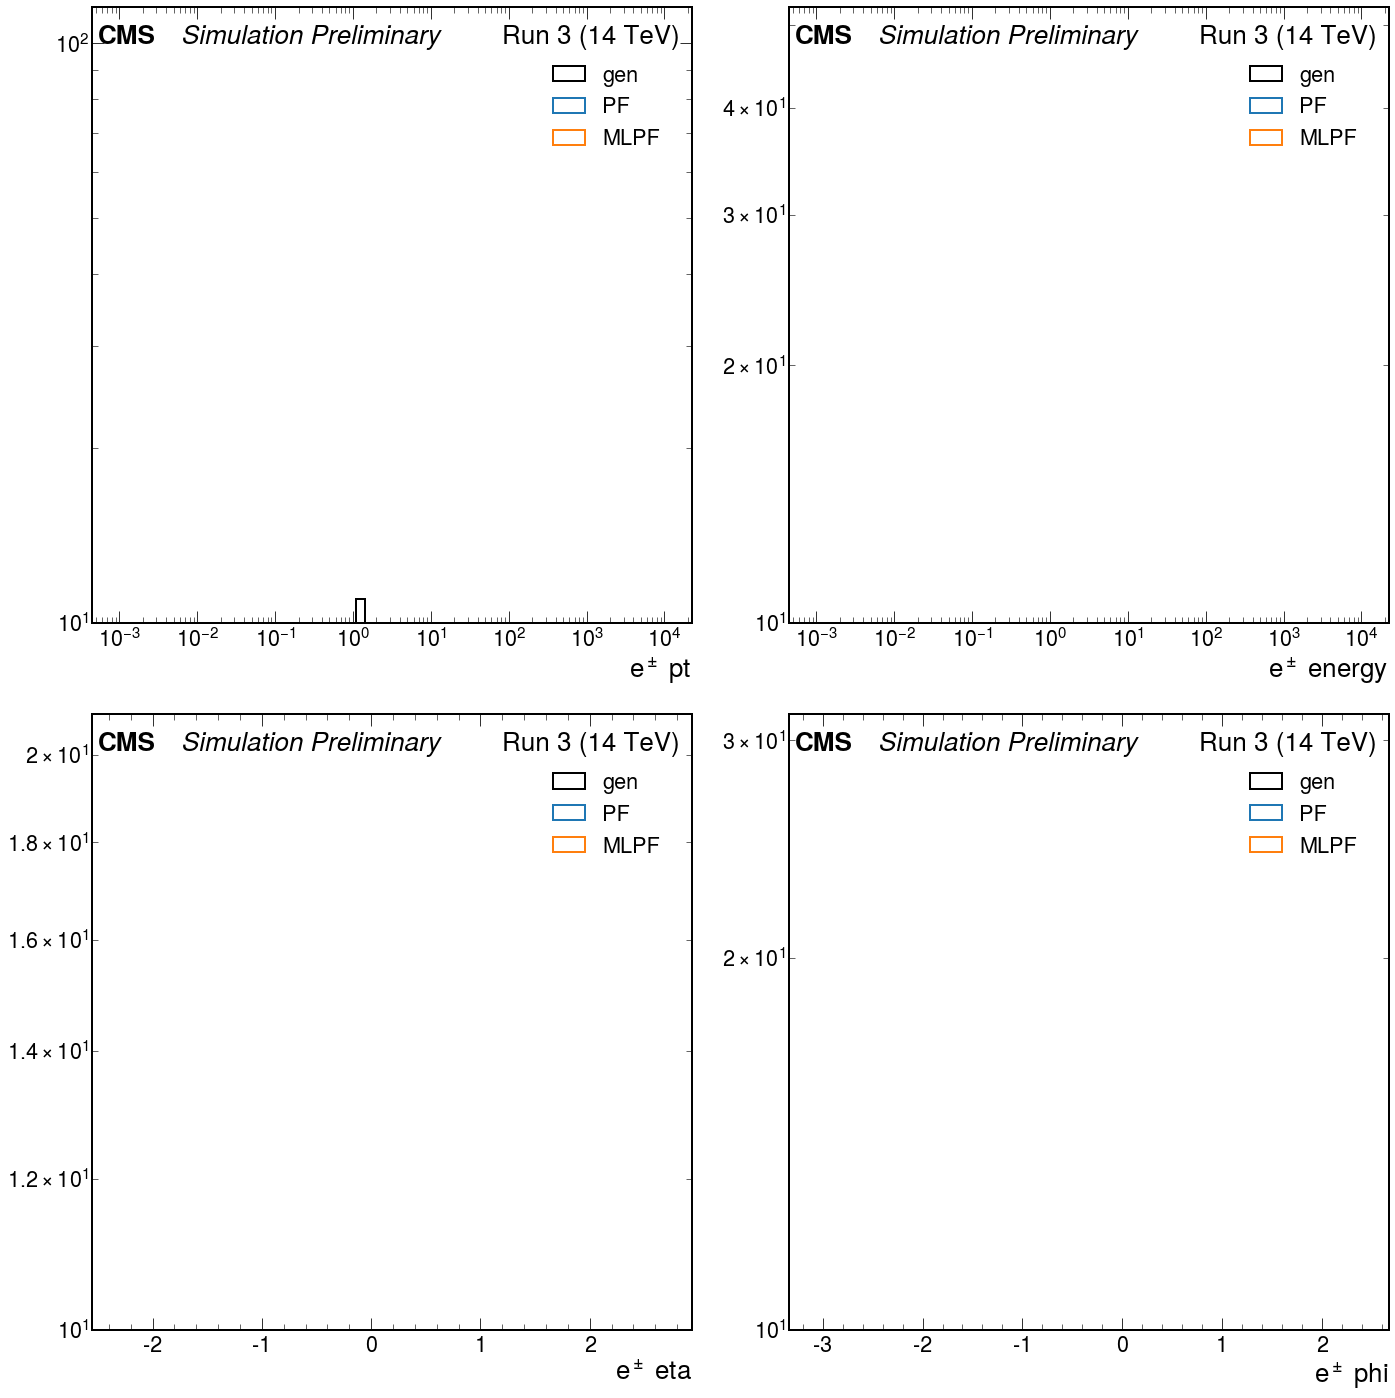

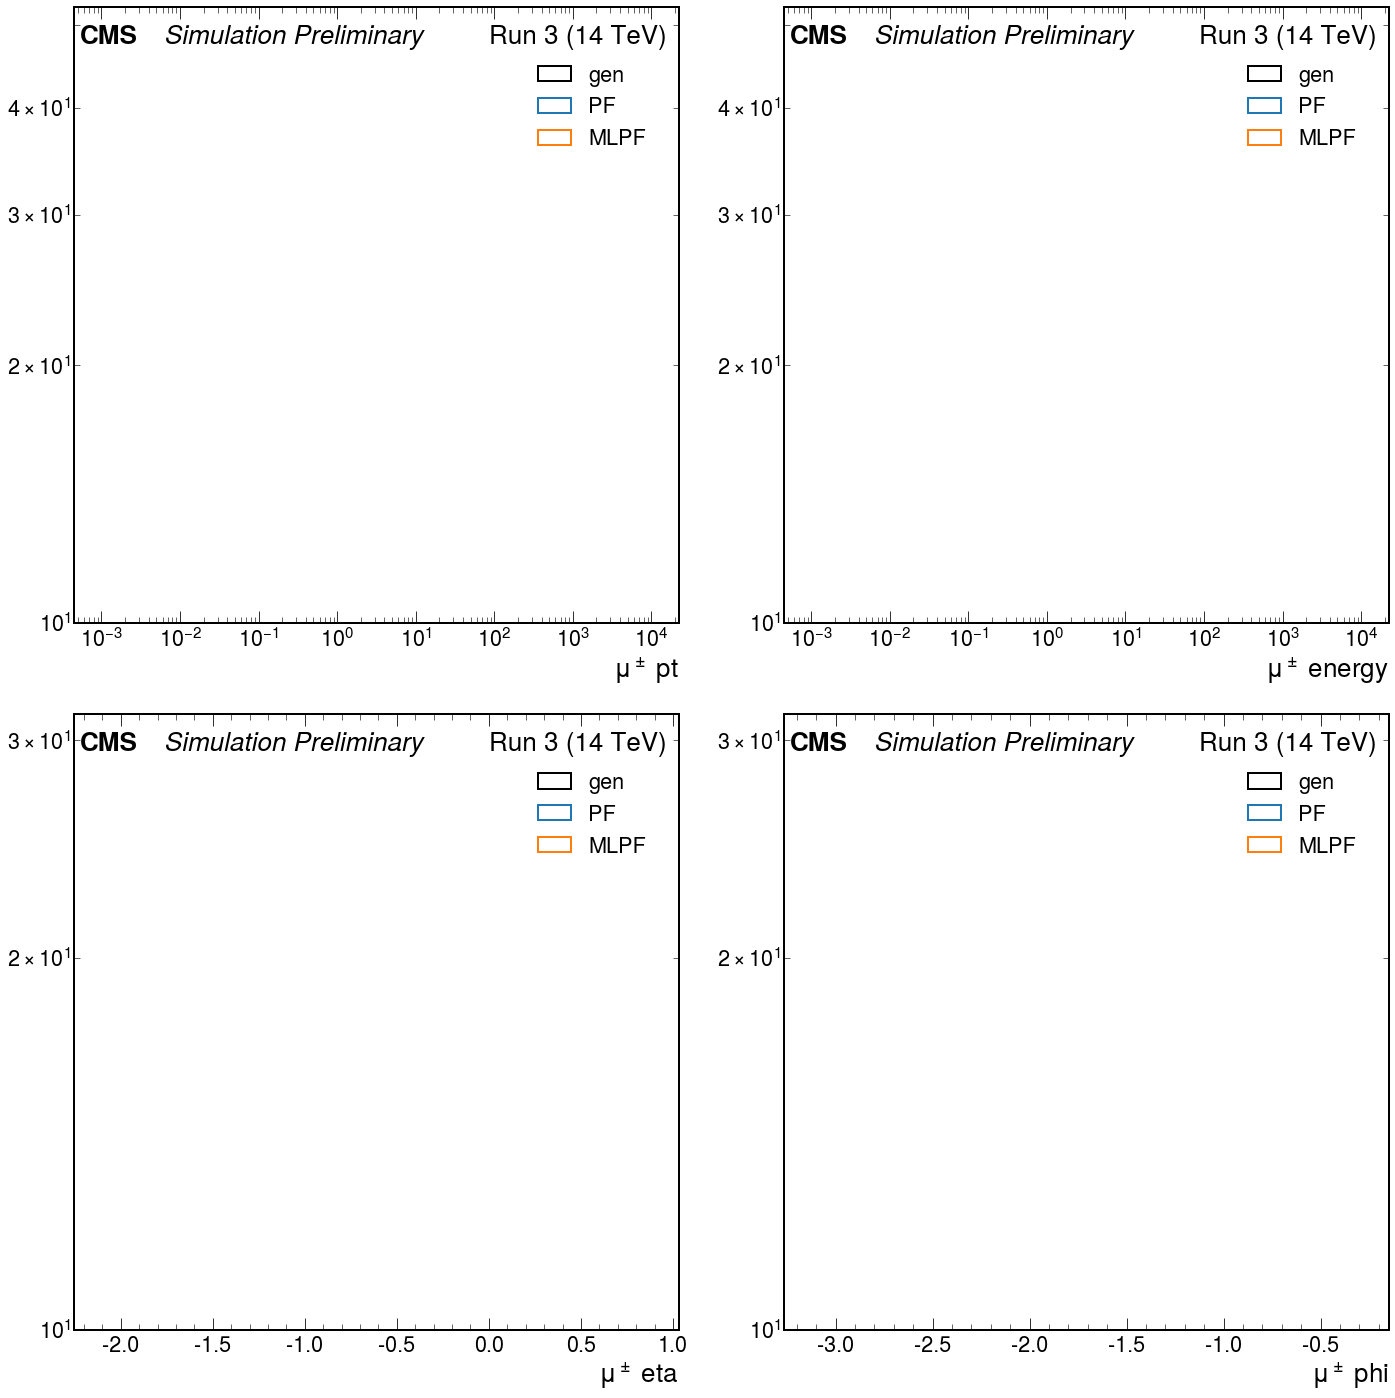

In [29]:
for icls in range(0, 8):
    fig, axs = plt.subplots(
        2,2,
        figsize=(2*mplhep.styles.CMS["figure.figsize"][0], 2*mplhep.styles.CMS["figure.figsize"][1])
    )
    
    for ax, ivar in zip(axs.flatten(), ["pt", "energy", "eta", "phi"]):
        
        plt.sca(ax)
        
        if icls == 0:
            vals_true = yvals_f["gen_" + ivar][yvals_f["gen_cls_id"]!=0]
            vals_pf = yvals_f["cand_" + ivar][yvals_f["cand_cls_id"]!=0]
            vals_pred = yvals_f["pred_" + ivar][yvals_f["pred_cls_id"]!=0]
        else:
            vals_true = yvals_f["gen_" + ivar][yvals_f["gen_cls_id"]==icls]
            vals_pf = yvals_f["cand_" + ivar][yvals_f["cand_cls_id"]==icls]
            vals_pred = yvals_f["pred_" + ivar][yvals_f["pred_cls_id"]==icls]
        
        if ivar == "pt" or ivar == "energy":
            b = np.logspace(-3, 4, 61)
            log = True
        else:
            b = np.linspace(np.min(vals_true), np.max(vals_true), 41)
            log = False
            
        plt.hist(vals_true, bins=b, histtype="step", lw=2, label="gen", color="black");
        plt.hist(vals_pf, bins=b, histtype="step", lw=2, label="PF");
        plt.hist(vals_pred, bins=b, histtype="step", lw=2, label="MLPF");
        plt.legend(loc=(0.75, 0.75))
        
        ylim = ax.get_ylim()
            
        cls_name = CLASS_NAMES_CMS[icls] if icls>0 else "all"
        plt.xlabel("{} {}".format(cls_name, ivar))
        
        plt.yscale("log")
        plt.ylim(10, 10*ylim[1])
        
        
        if log:
            plt.xscale("log")
        cms_label(ax)
        
    plt.tight_layout()
    plt.savefig("distribution_icls{}.pdf".format(icls), bbox_inches="tight")
    plt.savefig("distribution_icls{}.png".format(icls), dpi=300, bbox_inches="tight")

In [30]:
def plot_particle_regression(
    ivar="energy", icls=2,
    particle_label="Neutral hadrons",
    log=True,
    minval=-1,
    maxval=3,
    norm=matplotlib.colors.LogNorm()):
    
    plt.figure(figsize=(8,7))
    ax = plt.axes()
    
    bins = np.linspace(minval, maxval, 100)
    msk_both = (yvals_f["pred_cls_id"] == icls) & (yvals_f["gen_cls_id"]==icls)
    
    vals_true = yvals_f["gen_"+ivar][msk_both]
    vals_pred = yvals_f["pred_"+ivar][msk_both]
    
    if log:
        vals_true = np.log10(vals_true)
        vals_pred = np.log10(vals_pred)
    
    plt.hist2d(
        vals_true,
        vals_pred,
        bins=(bins, bins),
        cmap="Blues", norm=norm
    )
    
    plt.colorbar()
    plt.plot([minval, maxval], [minval, maxval], color="black", ls="--", lw=0.5)
    plt.xlim(minval, maxval)
    plt.ylim(minval, maxval)
    #cms_label(ax)
    #plt.text(0.02, 0.94, particle_label, transform=ax.transAxes)
    ax.set_xticks(ax.get_yticks());

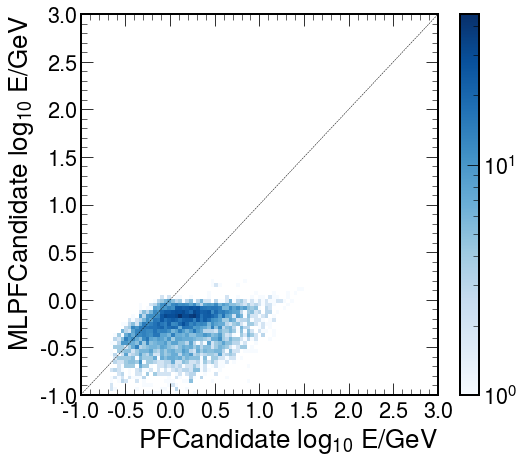

In [31]:
plot_particle_regression(ivar="energy", icls=1, particle_label="Charged hadrons")
plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
plt.savefig("energy_corr_cls1_log.pdf", bbox_inches="tight")
plt.savefig("energy_corr_cls1_log.png", bbox_inches="tight", dpi=300)

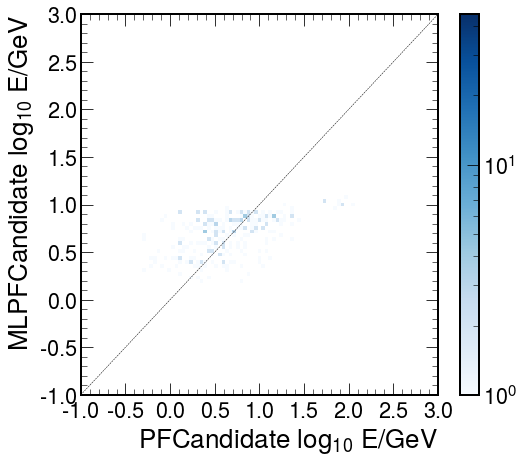

In [32]:
plot_particle_regression(ivar="energy", icls=2, particle_label="Neutral hadrons")
plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
plt.savefig("energy_corr_cls2_log.pdf", bbox_inches="tight")
plt.savefig("energy_corr_cls2_log.png", bbox_inches="tight", dpi=300)

In [ ]:
# plot_particle_regression(ivar="eta", icls=1, particle_label="Charged hadrons", log=False, minval=-4, maxval=4)
# plt.xlabel("PFCandidate $\eta$")
# plt.ylabel("MLPFCandidate $\eta$")
# plt.savefig("eta_corr_cls1_log.pdf", bbox_inches="tight")
# plt.savefig("eta_corr_cls1_log.png", bbox_inches="tight", dpi=300)

In [ ]:
# plot_particle_regression(ivar="eta", icls=2, particle_label="Neutral hadrons", log=False, minval=-4, maxval=4)
# plt.xlabel("PFCandidate $\eta$")
# plt.ylabel("MLPFCandidate $\eta$")
# plt.savefig("eta_corr_cls2_log.pdf", bbox_inches="tight")
# plt.savefig("eta_corr_cls2_log.png", bbox_inches="tight", dpi=300)

In [ ]:
# plot_particle_regression(ivar="energy", icls=3, particle_label="HFEM", minval=0.0, maxval=4)
# plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
# plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
# plt.savefig("energy_corr_cls3_log.pdf", bbox_inches="tight")
# plt.savefig("energy_corr_cls3_log.png", bbox_inches="tight", dpi=300)

In [ ]:
# plot_particle_regression(ivar="energy", icls=4, particle_label="HFHAD", minval=0.0, maxval=4)
# plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
# plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
# plt.savefig("energy_corr_cls4_log.pdf", bbox_inches="tight")
# plt.savefig("energy_corr_cls4_log.png", bbox_inches="tight", dpi=300)

In [ ]:
# plot_particle_regression(ivar="energy", icls=5, particle_label="gamma", minval=0.0, maxval=4)
# plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
# plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
# plt.savefig("energy_corr_cls5_log.pdf", bbox_inches="tight")
# plt.savefig("energy_corr_cls5_log.png", bbox_inches="tight", dpi=300)

In [ ]:
# plot_particle_regression(ivar="energy", icls=6, particle_label="e", minval=0.0, maxval=4)
# plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
# plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
# plt.savefig("energy_corr_cls6_log.pdf", bbox_inches="tight")
# plt.savefig("energy_corr_cls6_log.png", bbox_inches="tight", dpi=300)

In [ ]:
# plot_particle_regression(ivar="energy", icls=7, particle_label="mu", minval=0.0, maxval=4)
# plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
# plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
# plt.savefig("energy_corr_cls7_log.pdf", bbox_inches="tight")
# plt.savefig("energy_corr_cls7_log.png", bbox_inches="tight", dpi=300)